## Credit Card Fraud Detection

### Problem Statement :

The objective of this project is to predict fraudulent credit card transactions using machine learning models.

In this project, customer-level data, collected and analyzed through a collaboration between Worldline and the Machine Learning Group, will be examined.

Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset, sourced from Kaggle, comprises 284,807 transactions, with 492 identified as fraudulent. Given the highly imbalanced nature of the dataset, it requires appropriate handling before model development.


## **Project Pipeline :**

Data Understanding: Load and explore the dataset to comprehend the features it contains. This helps in selecting the necessary features for the final model.

Exploratory Data Analysis (EDA): Perform analyses of the data, followed by feature transformations if needed. Check for any data skewness and mitigate it to avoid issues during model building.

Train/Test Split: Implement the train/test split to evaluate model performance with unseen data. Use k-fold cross-validation for validation, selecting an appropriate k value to ensure the minority class is accurately represented in the test folds.

Model Building/Hyperparameter Tuning: Experiment with different models and fine-tune their hyperparameters to achieve the desired performance on the dataset. Explore various sampling techniques to potentially improve model performance.

Model Evaluation: Assess the models using relevant evaluation metrics. Given the imbalanced nature of the data, prioritize metrics that accurately identify fraudulent transactions over non-fraudulent ones. Choose evaluation metrics that align with this business goal.

## About the Dataset:

The data set is taken from the Kaggle website and has a total of 2,84,807 transactions; out of these, 492 are fraudulent. Since the data set is highly imbalanced, it needs to be handled before model building.

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Metric Used For Evaluation

#### ROC-AUC Score:

The ROC curve is used to understand the strength of the model by evaluating the performance of the model at all the classification thresholds.

Since the ROC curve is measured at all thresholds, the best threshold would be one at which the TPR is high and FPR is low, i.e., misclassifications are low.

Other metrics like precision,recall and F1-score are dependent on threshold.

We will use sklearn.metrics.roc_auc_score for this as the AUC and ROC metrics in scikit-learn are designed for highly imbalanced datasets, whereas other metrics often fail. The ROC metric has better false negative rates than false positive rates.

The ROC curve is a plot between the True Positive Rate (TPR) and False Positive Rate (FPR). The threshold with the highest value for TPR-FPR on the training set is usually the optimal cut-off.

We should avoid using the confusion matrix as a performance metric because it relies on a hard threshold of 0.5. Similarly, precision, recall, and F1-score are also dependent on specific threshold values and cannot be fully relied upon at this stage.

The ROC curve takes all possible threshold values into account. It is used to evaluate the strength of the model by analyzing its performance across all classification thresholds. The optimal threshold is one where the TPR is high and the FPR is low, leading to minimal misclassifications.


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

!pip install scikit-learn==1.3.2
!pip install xgboost

import xgboost as xgb
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.preprocessing import  RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
#!pip install -U imbalanced-learn
import imblearn
from imblearn import over_sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

pd.set_option("display.max_columns", None)
pd.set_option('float_format', '{:f}'.format)

import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis

In [7]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0


In [8]:
#observe the different feature type present in the data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Here we will observe the distribution of our classes

In [10]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

In [11]:
print("Number of normal transactions: ", classes[0])
print("Number of fraud transactions: ", classes[1])

Number of normal transactions:  284315
Number of fraud transactions:  492


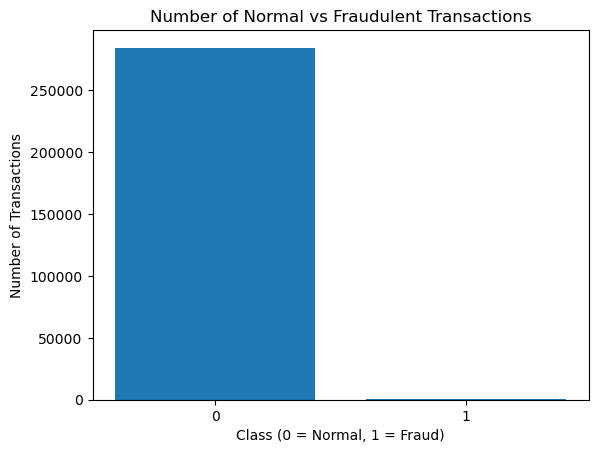

In [12]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations

plt.bar(classes.index.astype(str), classes.values)
plt.xlabel("Class (0 = Normal, 1 = Fraud)")
plt.ylabel("Number of Transactions")
plt.title("Number of Normal vs Fraudulent Transactions")
plt.show()


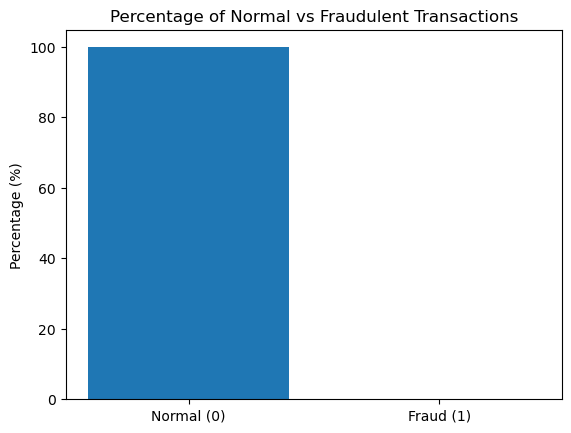

In [13]:
# Bar plot for percentages
plt.bar(["Normal (0)", "Fraud (1)"], [normal_share, fraud_share])
plt.ylabel("Percentage (%)")
plt.title("Percentage of Normal vs Fraudulent Transactions")
plt.show()

### Observation :

1. The dataset exhibits a significant class imbalance, with only 492 out of 284,807 records classified as fraudulent transactions.
2. This represents a distribution of 99.83% for the majority (non-fraudulent) class and 0.17% for the minority (fraudulent) class.

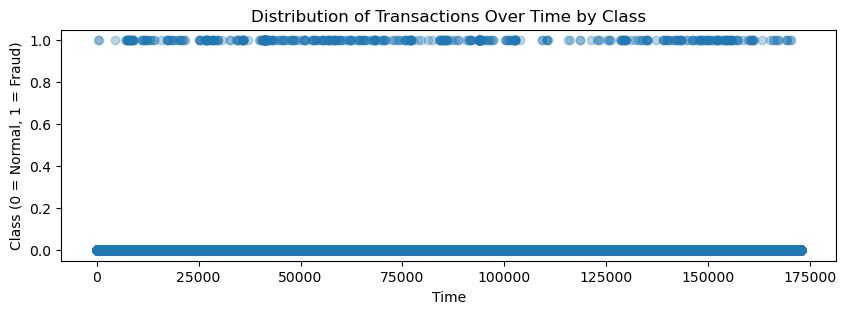

In [15]:
# Create a scatter plot to observe the distribution of classes with time

plt.figure(figsize=(10,3))
plt.scatter(df['Time'], df['Class'], alpha=0.3)
plt.xlabel("Time")
plt.ylabel("Class (0 = Normal, 1 = Fraud)")
plt.title("Distribution of Transactions Over Time by Class")
plt.show()

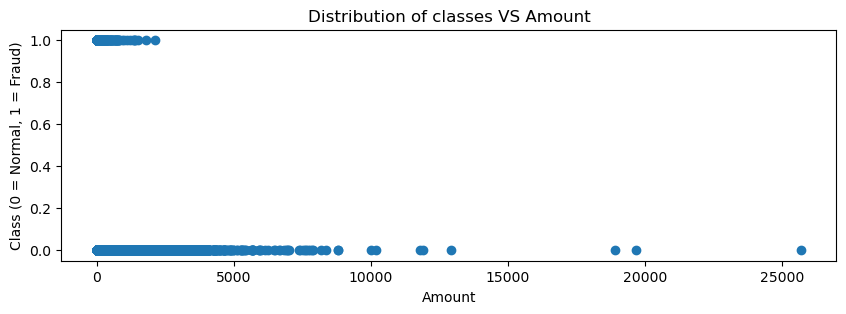

In [16]:
# Create a scatter plot to observe the distribution of classes with Amount

plt.figure(figsize=(10,3))
plt.scatter(y=df['Class'], x=df['Amount'])

plt.xlabel("Amount")
plt.ylabel("Class (0 = Normal, 1 = Fraud)")
plt.title('Distribution of classes VS Amount')
plt.show()

In [17]:
df_fraud = df[df['Class'] == 1]
df_non_fraud = df[df['Class'] == 0]

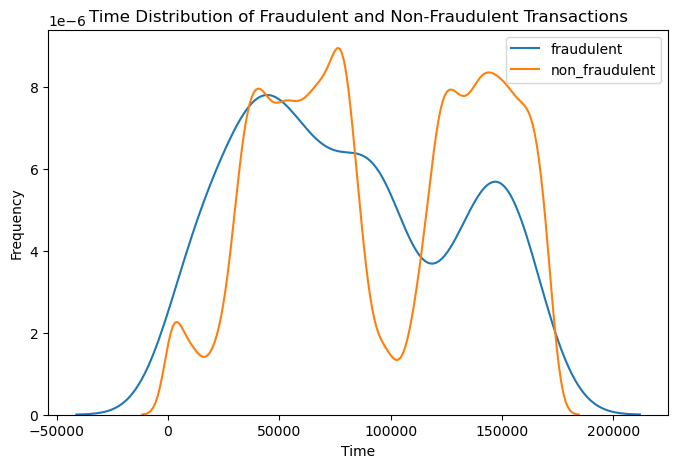

In [18]:
plt.figure(figsize=(8, 5))

# Plot the distribution of 'Time' for fraudulent transactions without the histogram
ax = sns.distplot(df_fraud['Time'], label='fraudulent', hist=False)

# Plot the distribution of 'Time' for non-fraudulent transactions without the histogram
ax = sns.distplot(df_non_fraud['Time'], label='non_fraudulent', hist=False)

ax.set(xlabel='Time', ylabel='Frequency')
plt.title('Time Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.legend(loc='best')
plt.show()

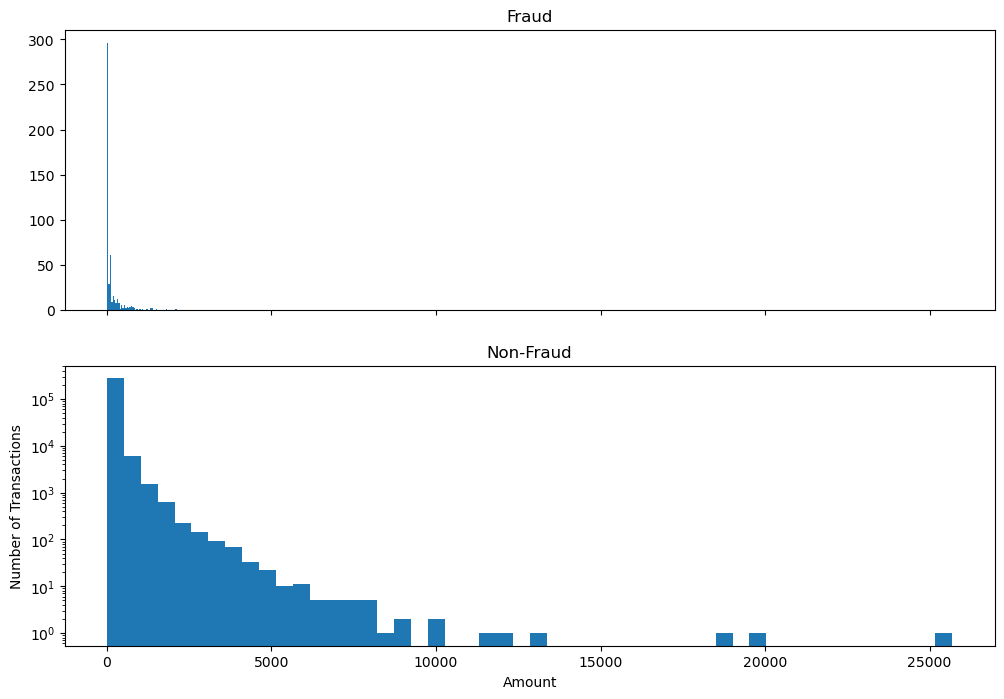

In [19]:
# Plotting histogram for fraud and non-fraud transactions

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Plot the histogram of 'Amount' for fraudulent transactions with 50 bins
ax1.hist(df_fraud['Amount'], bins=50)
ax1.set_title('Fraud')

# Plot the histogram of 'Amount' for non-fraudulent transactions with 50 bins
ax2.hist(df_non_fraud['Amount'], bins=50)
ax2.set_title('Non-Fraud')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()


### Observation  :  

It is visible that low amount transactions are more likely to be fraudelent transactions when compared with high amounts

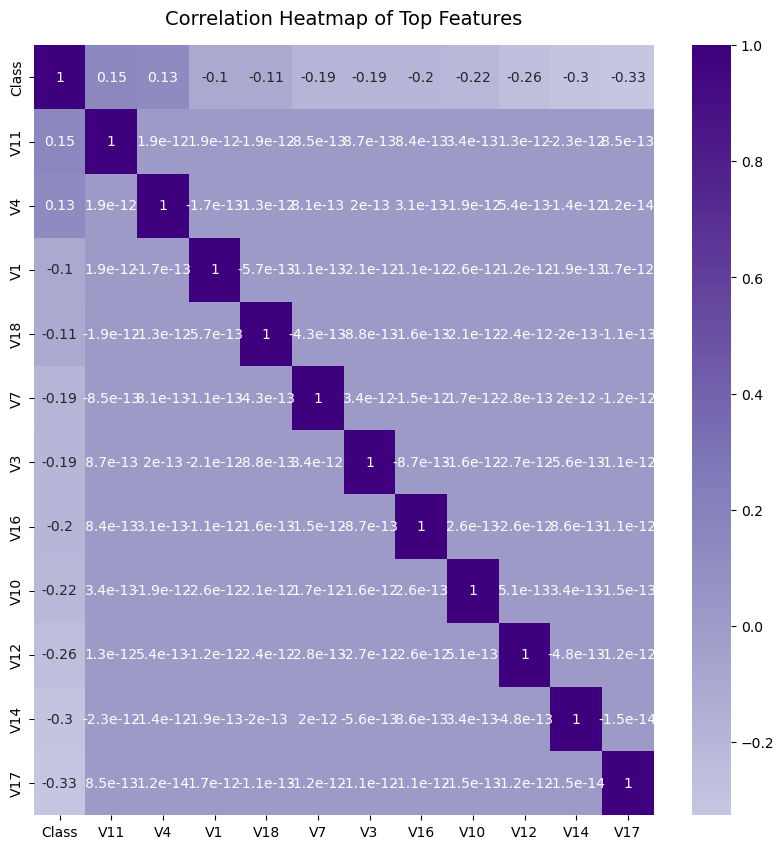

In [21]:
# Coorelation 

correlations = df.corr()['Class']

# Create a DataFrame to store the correlations
correlations_df = pd.DataFrame({'Correlation': correlations})
sorted_correlations = correlations_df.sort_values(by=['Correlation'], ascending=False)

top_features = sorted_correlations.index[abs(sorted_correlations['Correlation']) > 0.1]

top_corr_matrix = df[top_features].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='Purples', center=0)
plt.title("Correlation Heatmap of Top Features", fontsize=14, pad=15)
plt.show()

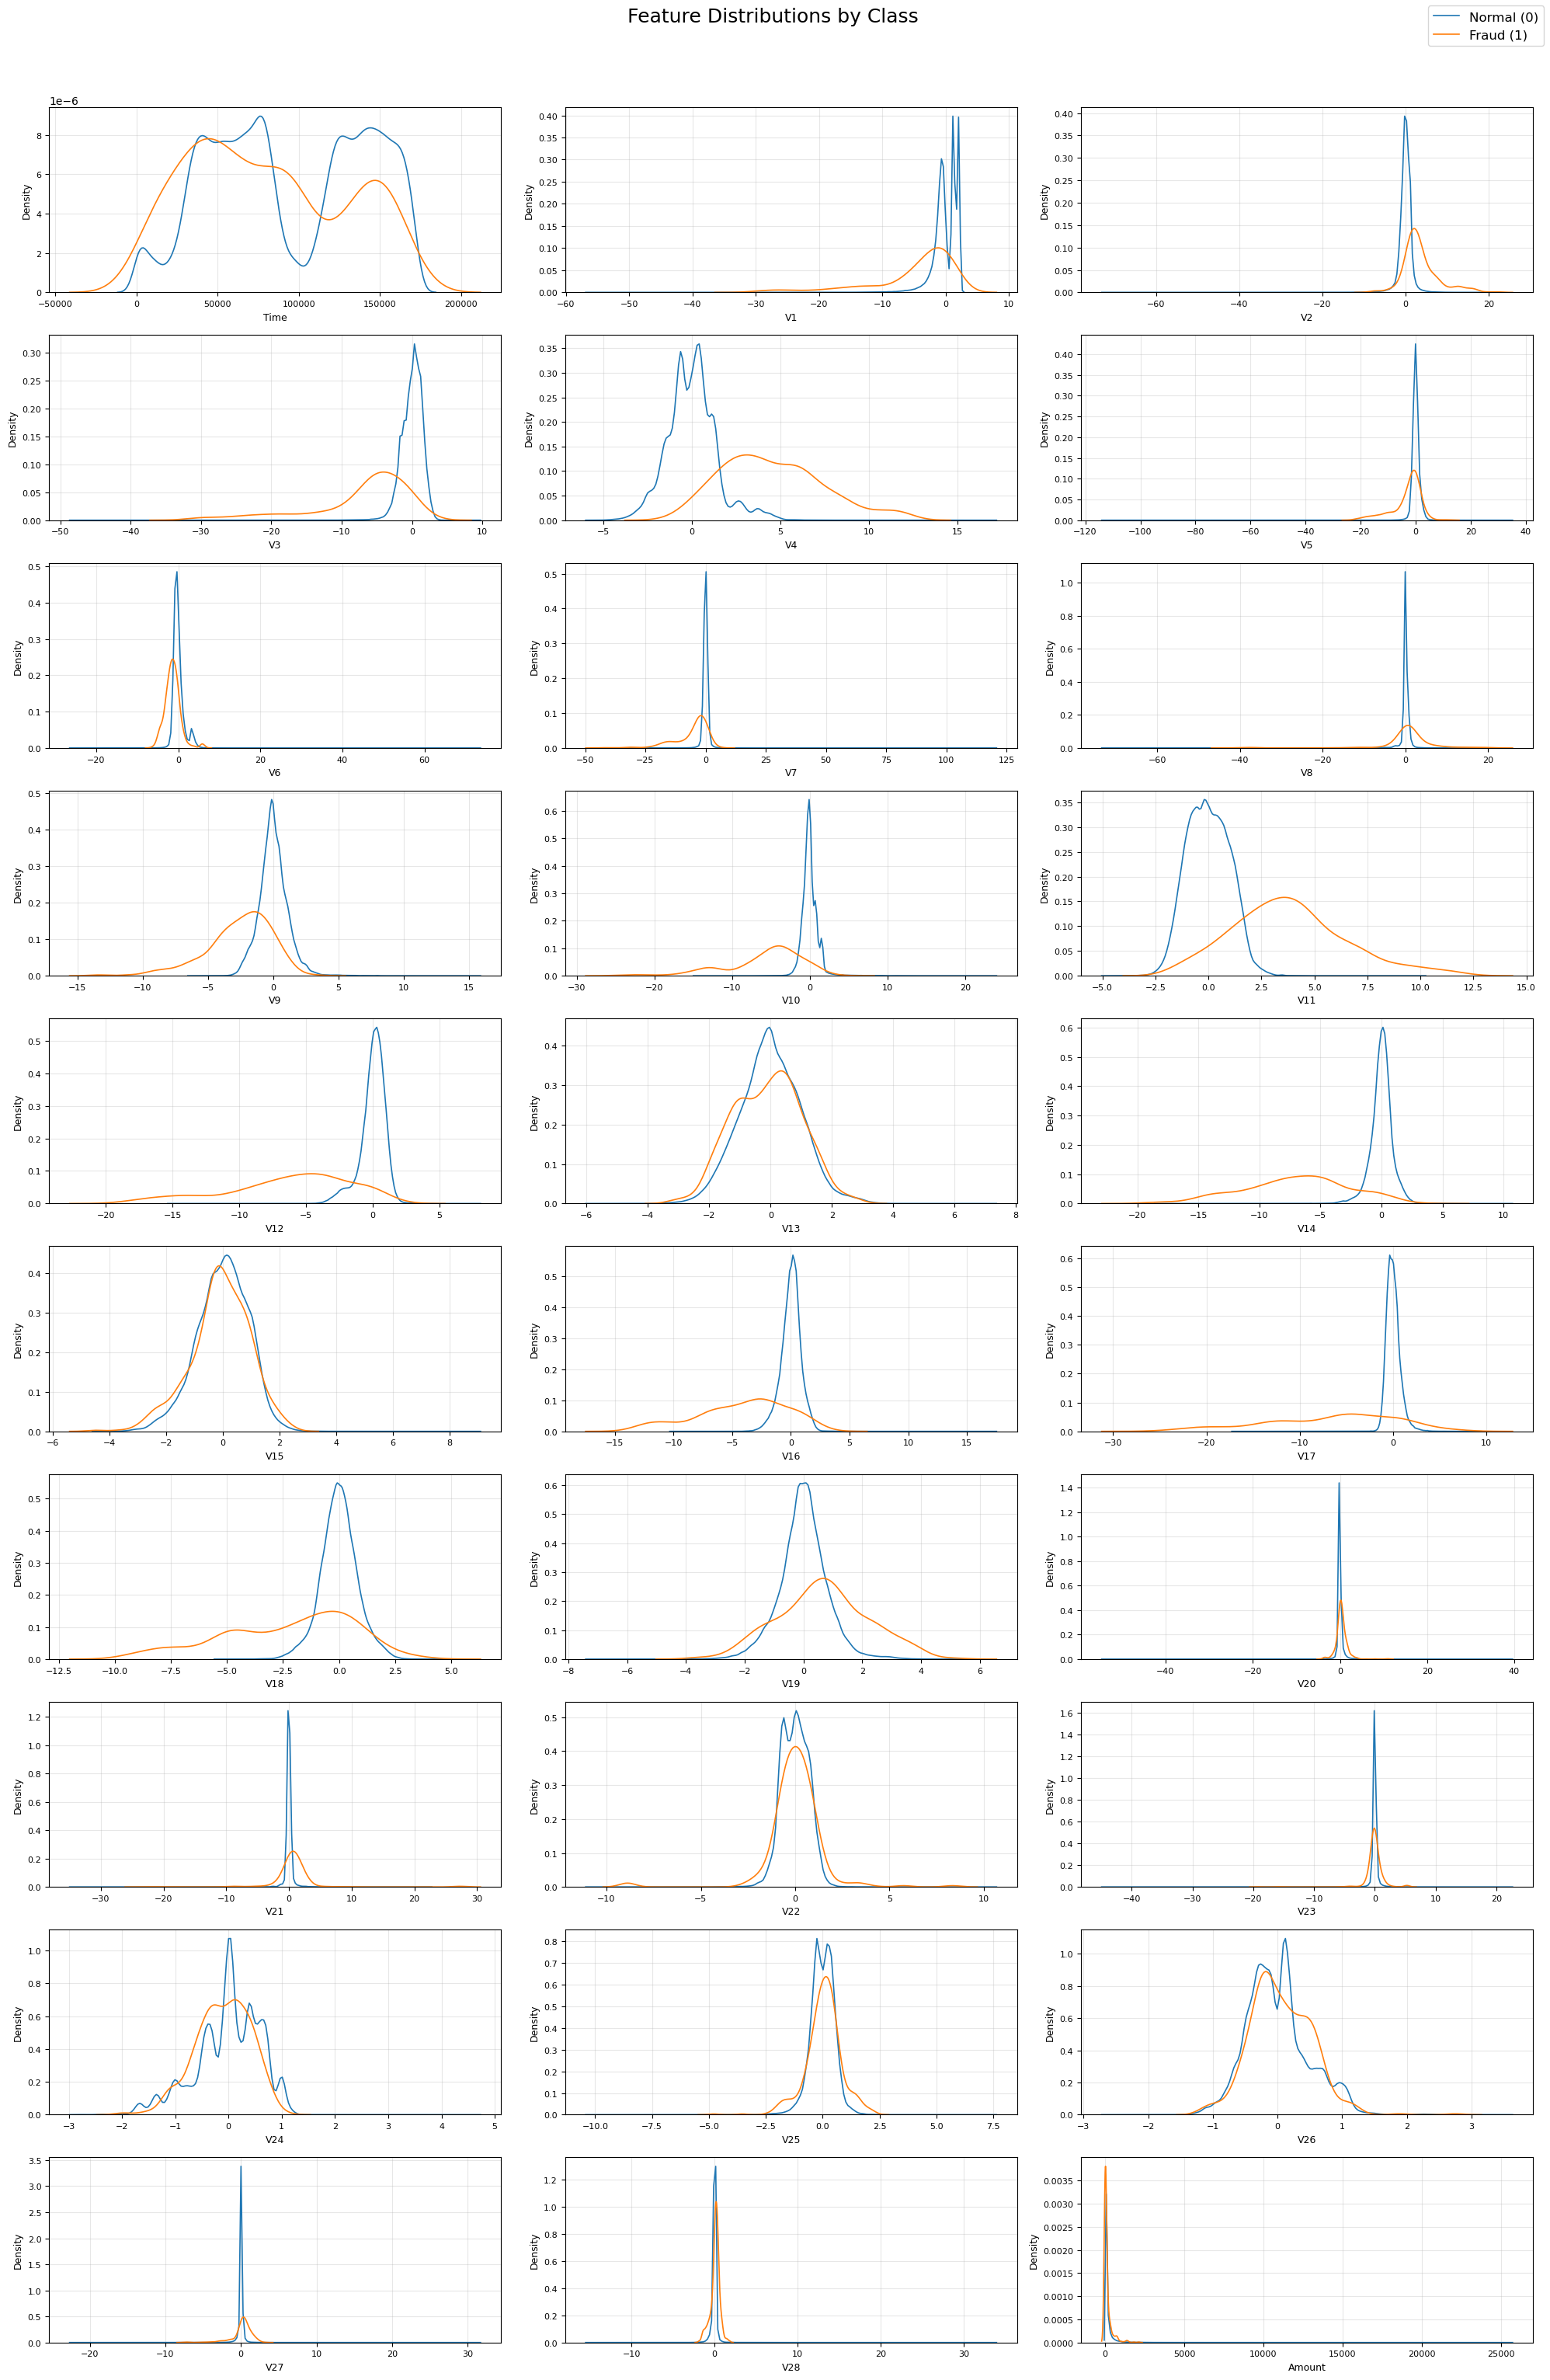

In [22]:
features = [col for col in df.columns if col != "Class"]

# Create subplots
fig, axes = plt.subplots(10, 3, figsize=(20, 30), facecolor="white")
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    sns.kdeplot(data=df[df['Class']==0][feature], label="Normal (0)", ax=axes[i], linewidth=1.2)
    sns.kdeplot(data=df[df['Class']==1][feature], label="Fraud (1)", ax=axes[i], linewidth=1.2)
    
    axes[i].set_xlabel(feature, fontsize=9)
    axes[i].set_ylabel("Density", fontsize=9)
    axes[i].tick_params(axis='both', labelsize=8)
    axes[i].grid(alpha=0.3)

# Remove empty subplots if features < total slots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Add one legend for all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=12)

fig.suptitle("Feature Distributions by Class", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


In [23]:
print("Numeric distribution of the data frame:")
print("_____________________________________________")
print(df.describe())

Numeric distribution of the data frame:
_____________________________________________
               Time            V1            V2            V3            V4  \
count 284807.000000 284807.000000 284807.000000 284807.000000 284807.000000   
mean   94813.859575      0.000000     -0.000000     -0.000000      0.000000   
std    47488.145955      1.958696      1.651309      1.516255      1.415869   
min        0.000000    -56.407510    -72.715728    -48.325589     -5.683171   
25%    54201.500000     -0.920373     -0.598550     -0.890365     -0.848640   
50%    84692.000000      0.018109      0.065486      0.179846     -0.019847   
75%   139320.500000      1.315642      0.803724      1.027196      0.743341   
max   172792.000000      2.454930     22.057729      9.382558     16.875344   

                 V5            V6            V7            V8            V9  \
count 284807.000000 284807.000000 284807.000000 284807.000000 284807.000000   
mean       0.000000      0.000000     -0.000

### Handling Missing Values

In [25]:
# Checking for the missing value present in each columns
total = df.isnull().sum()
percent = (df.isnull().mean()).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

,Total,Percent
Time,0,0.000000
V1,0,0.000000
V2,0,0.000000
V3,0,0.000000
V4,0,0.000000
V5,0,0.000000
V6,0,0.000000
V7,0,0.000000
V8,0,0.000000
V9,0,0.000000


In [26]:
# Drop unnecessary columns

# Based on the obervation from time vs class plot, we can say that time feature is not going to help in the model building so let us drop that .
df.drop('Time', axis = 1, inplace= True)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0


### Splitting the data into train & test data

In [28]:
y= df['Class']#class variable
X = df.drop("Class", axis=1)

In [29]:
print("y variable shape:",y.shape )
print("X variable shape:",X.shape )

y variable shape: (284807,)
X variable shape: (284807, 29)


In [30]:
from sklearn import model_selection

# The stratify parameter in train_test_split ensures the distribution of classes in split of the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [32]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


### Plotting the distribution of a variable

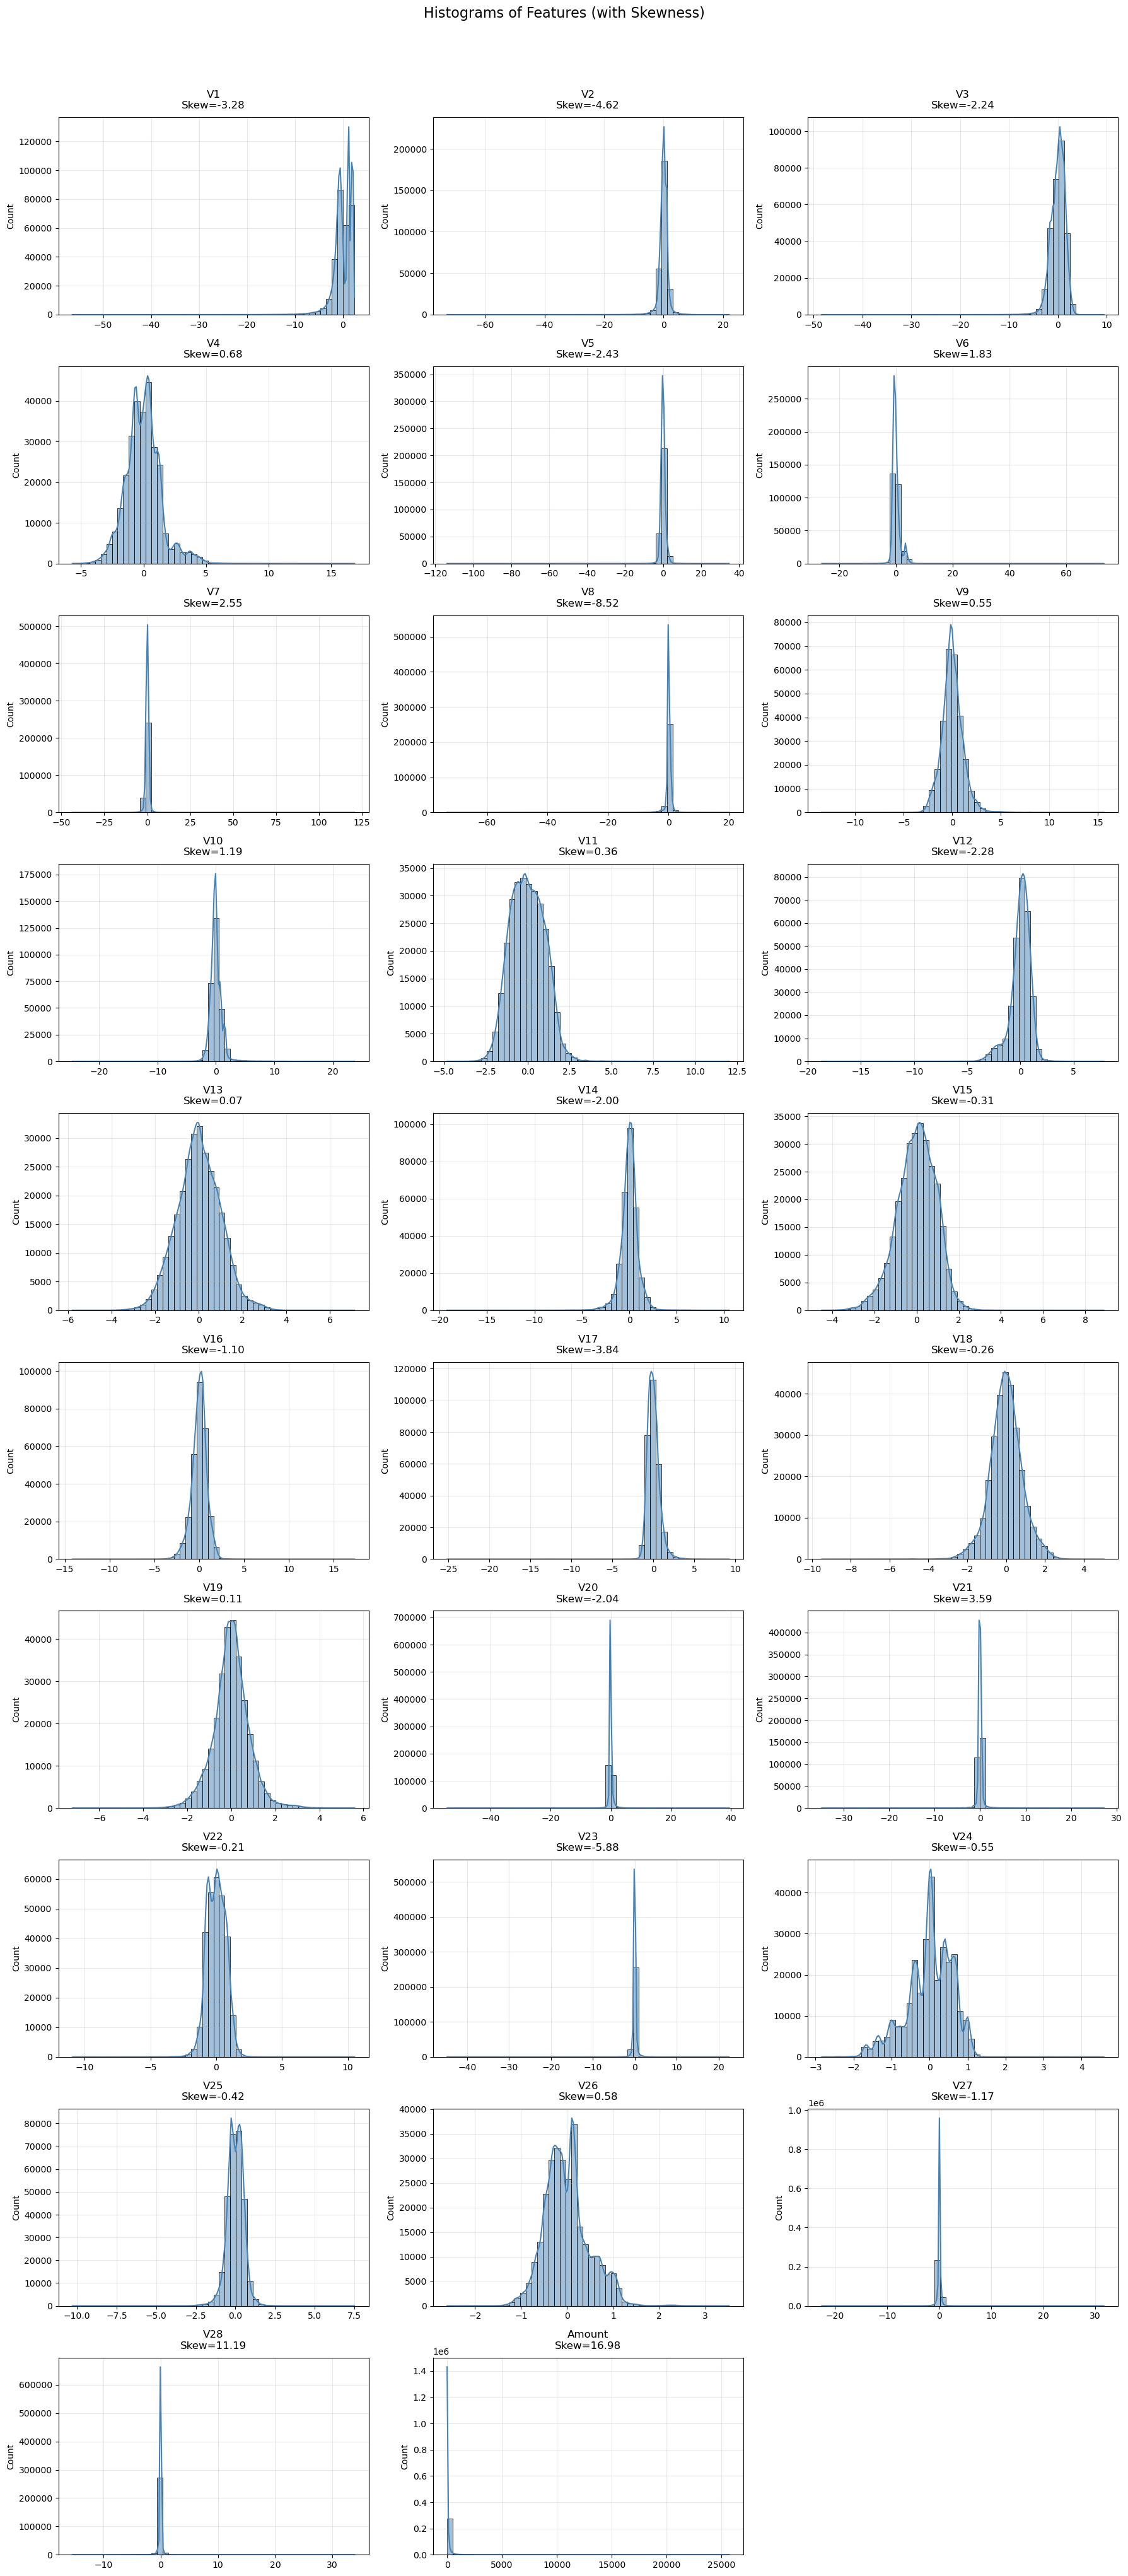

In [34]:
# plot the histogram of a variable from the dataset to see the skewness

# Select only numeric features (excluding target)
numeric_features = [col for col in df.columns if df[col].dtype != 'object' and col != 'Class']

# Define subplot grid size
n_cols = 3
n_rows = int(np.ceil(len(numeric_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4), facecolor="white")
axes = axes.flatten()

# Plot histograms
for i, feature in enumerate(numeric_features):
    sns.histplot(df[feature], bins=50, kde=True, color="steelblue", ax=axes[i])
    axes[i].set_title(f"{feature}\nSkew={df[feature].skew():.2f}", fontsize=12, pad=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].grid(alpha=0.3)

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histograms of Features (with Skewness)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [36]:
# Let's check the skewness of the features using skew(), if the skewness is beyond -1 to 1, then we will use power transform to transform the data.

var = X_train.columns
skew_list = []

for i in var:
    skew_list.append(X_train[i].skew())

# Combine the features and their corresponding skewness values into a DataFrame
skew_data = pd.concat([pd.DataFrame(var, columns=["Features"]), pd.DataFrame(skew_list, columns=["Skewness"])], axis=1)

skew_data.set_index("Features", inplace=True)

# Display the DataFrame containing features and their skewness values
skew_data

,Skewness
Features,
V1,-3.306334
V2,-4.779484
V3,-2.247962
V4,0.687574
V5,-2.786851
V6,1.937381
V7,3.152665
V8,-8.639485
V9,0.541869


### Feature Scaling using RobustScaler Scaler

In [38]:
# As PCA is already performed on the dataset from V1 to V28 features, we are scaling only Amount field which is in its raw form.
scaler = RobustScaler()

# Scaling the train data
X_train[["Amount"]] = scaler.fit_transform(X_train[["Amount"]])

# Transforming the test data
X_test[["Amount"]] = scaler.transform(X_test[["Amount"]])

### Impact of Skewed Data : 
Skewed data can negatively impact the performance of models, by reducing their ability to accurately describe typical cases. This happens because the model has to account for rare extreme values. For example, right-skewed data will result in better predictions for data points with lower values, while predictions for higher values may be less accurate.

In [40]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data

In [41]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', copy=True)

# Fit the PowerTransformer on the training data
pt.fit(X_train)

# Transform the training data
X_train_pt = pt.transform(X_train)

# Transform the testing data
X_test_pt = pt.transform(X_test)

In [42]:
print(X_train_pt.shape)
print(X_test_pt.shape)

(227845, 29)
(56962, 29)


In [43]:
X_train = pd.DataFrame(data=X_train_pt,columns=var)
X_test  = pd.DataFrame(data=X_test_pt, columns=var)

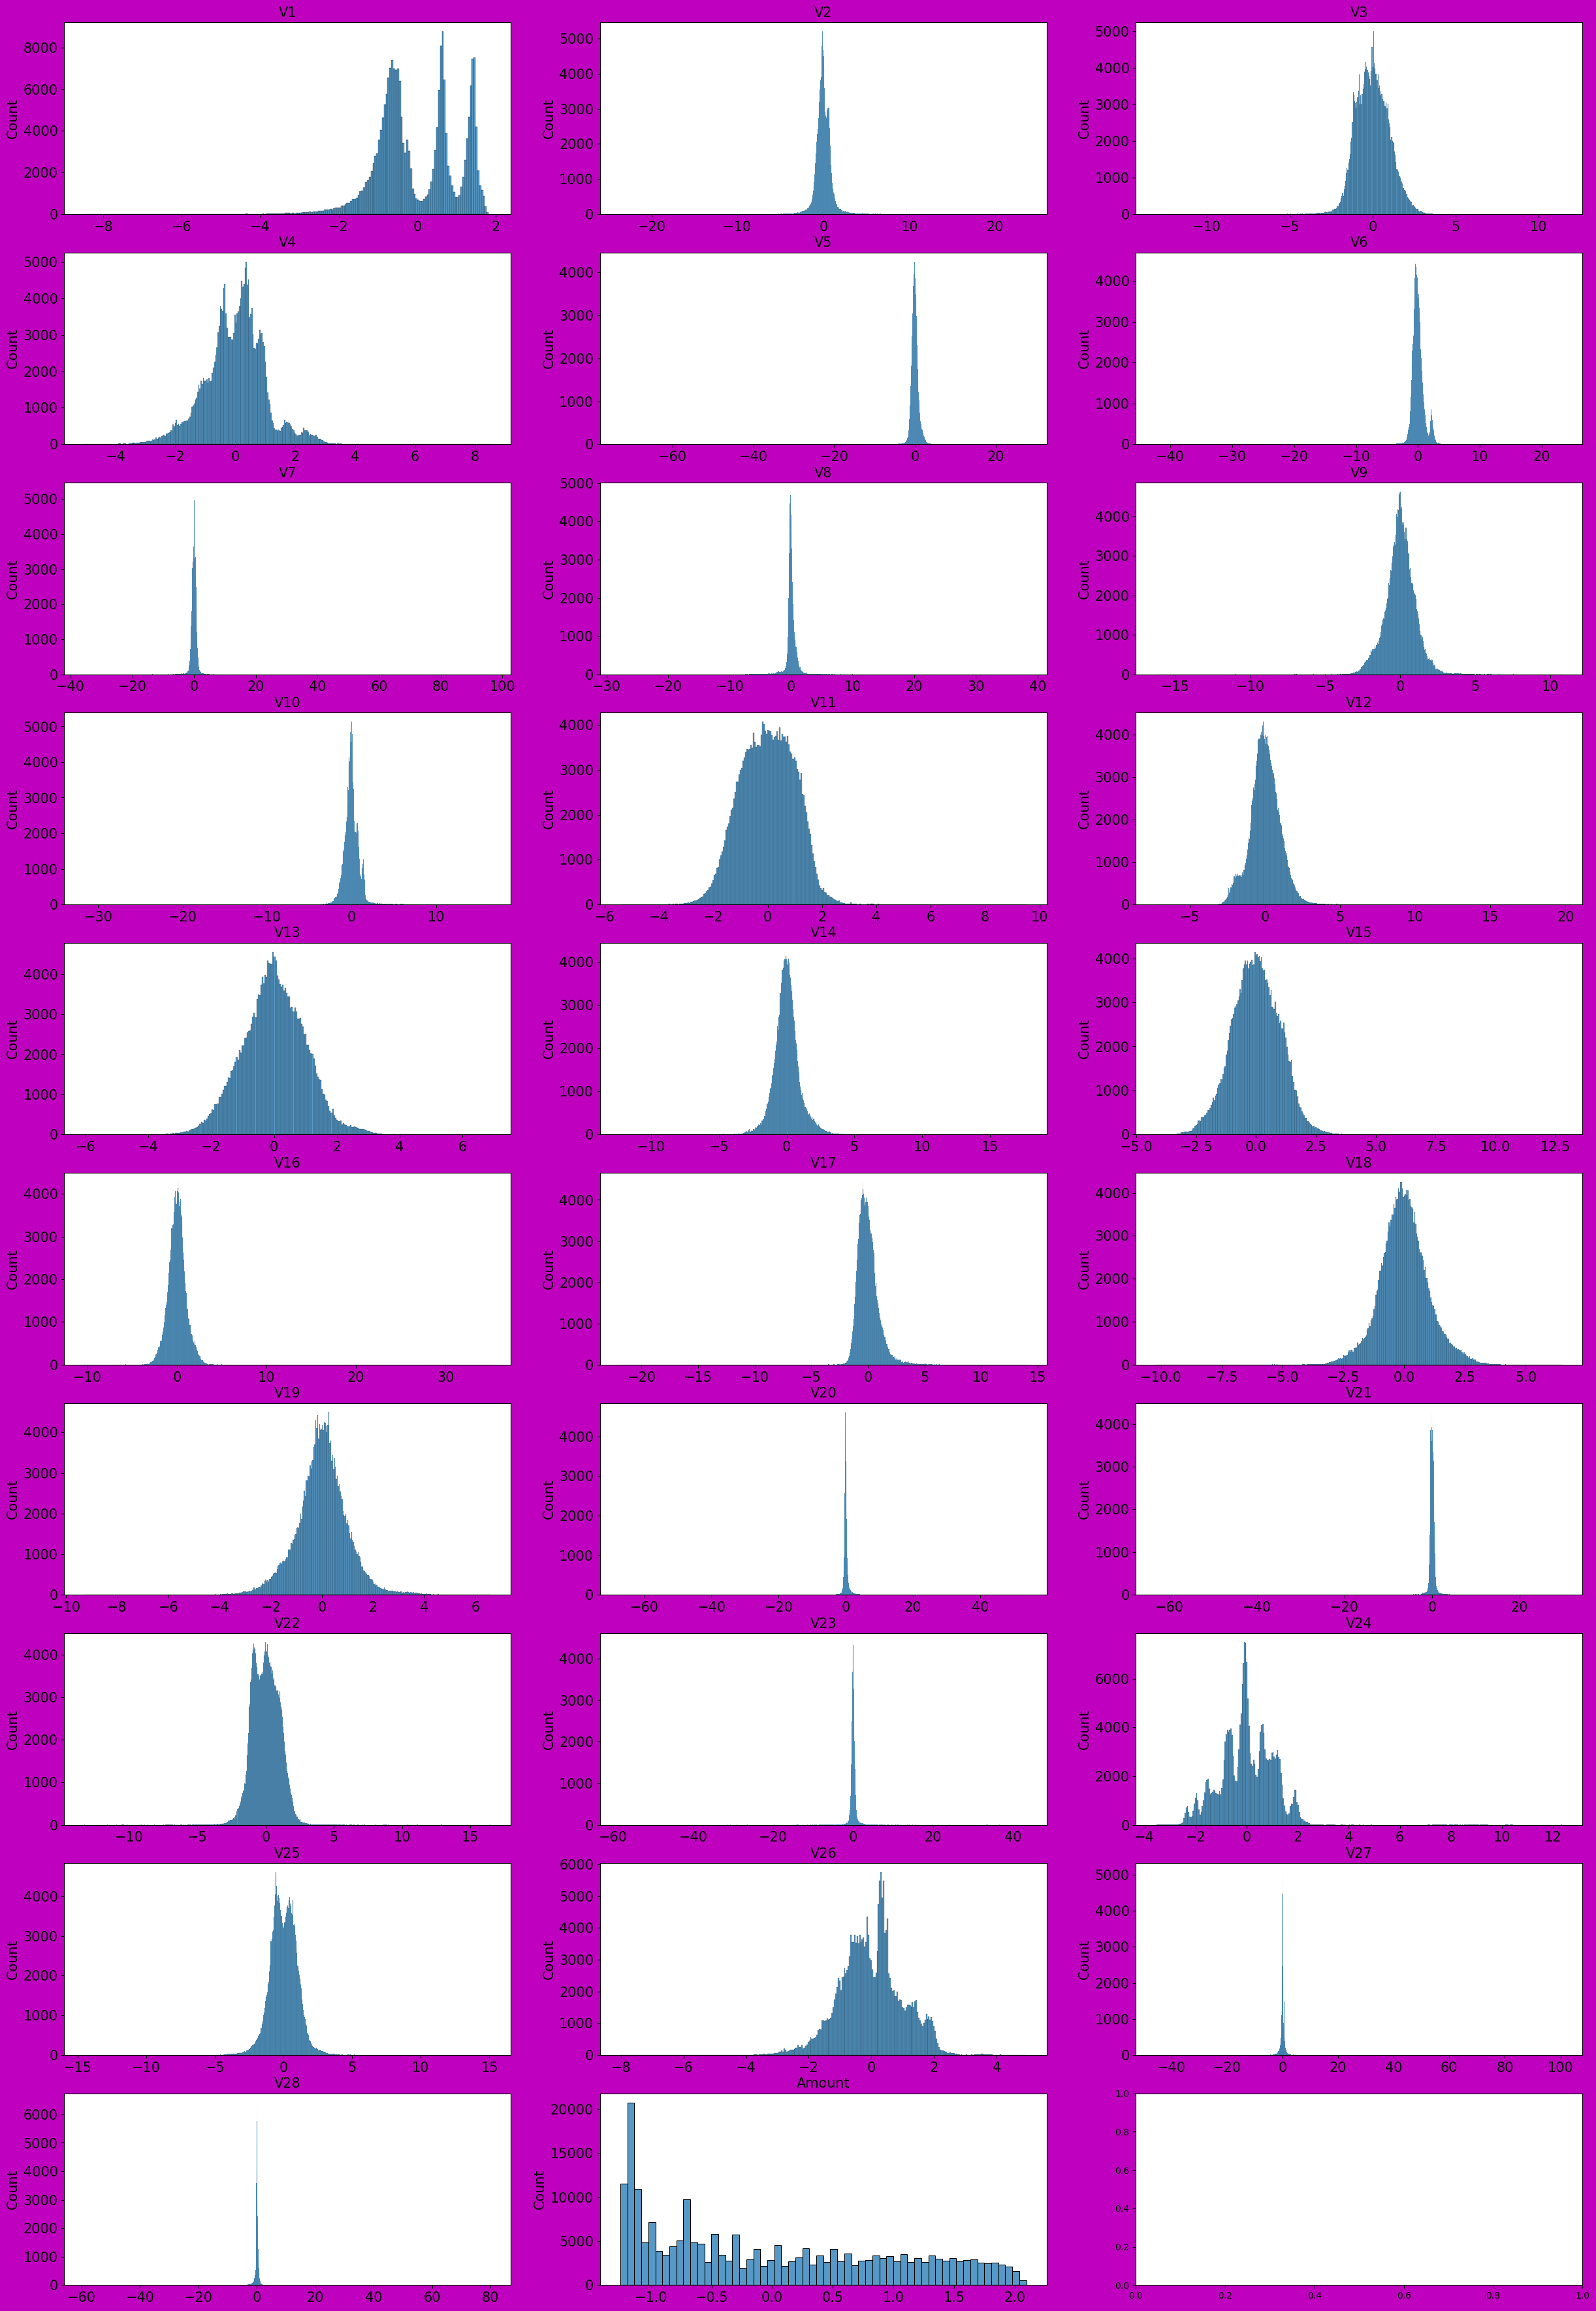

In [44]:
# Plot the histogram of a variable from the train dataset again to see the result after application of the PowerTransformer

# Create a list of all column names in the transformed training dataset
var = list(X_train.columns.values)

# Create a figure with 30 subplots (10 rows, 3 columns), with specified size and background color
fig, axes = plt.subplots(10, 3, figsize=(30, 45), facecolor='m')
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate over each feature and corresponding subplot axis
for i, ax in enumerate(axes):
    if i < len(var):
        sns.histplot(X_train[var[i]], ax=ax) 
        ax.set_title(var[i], fontsize=15) 
        ax.set_ylabel("Count", fontsize=15) 
        ax.tick_params(axis='both', labelsize=15)
        ax.set_xlabel('')

# Display the plots
plt.show()

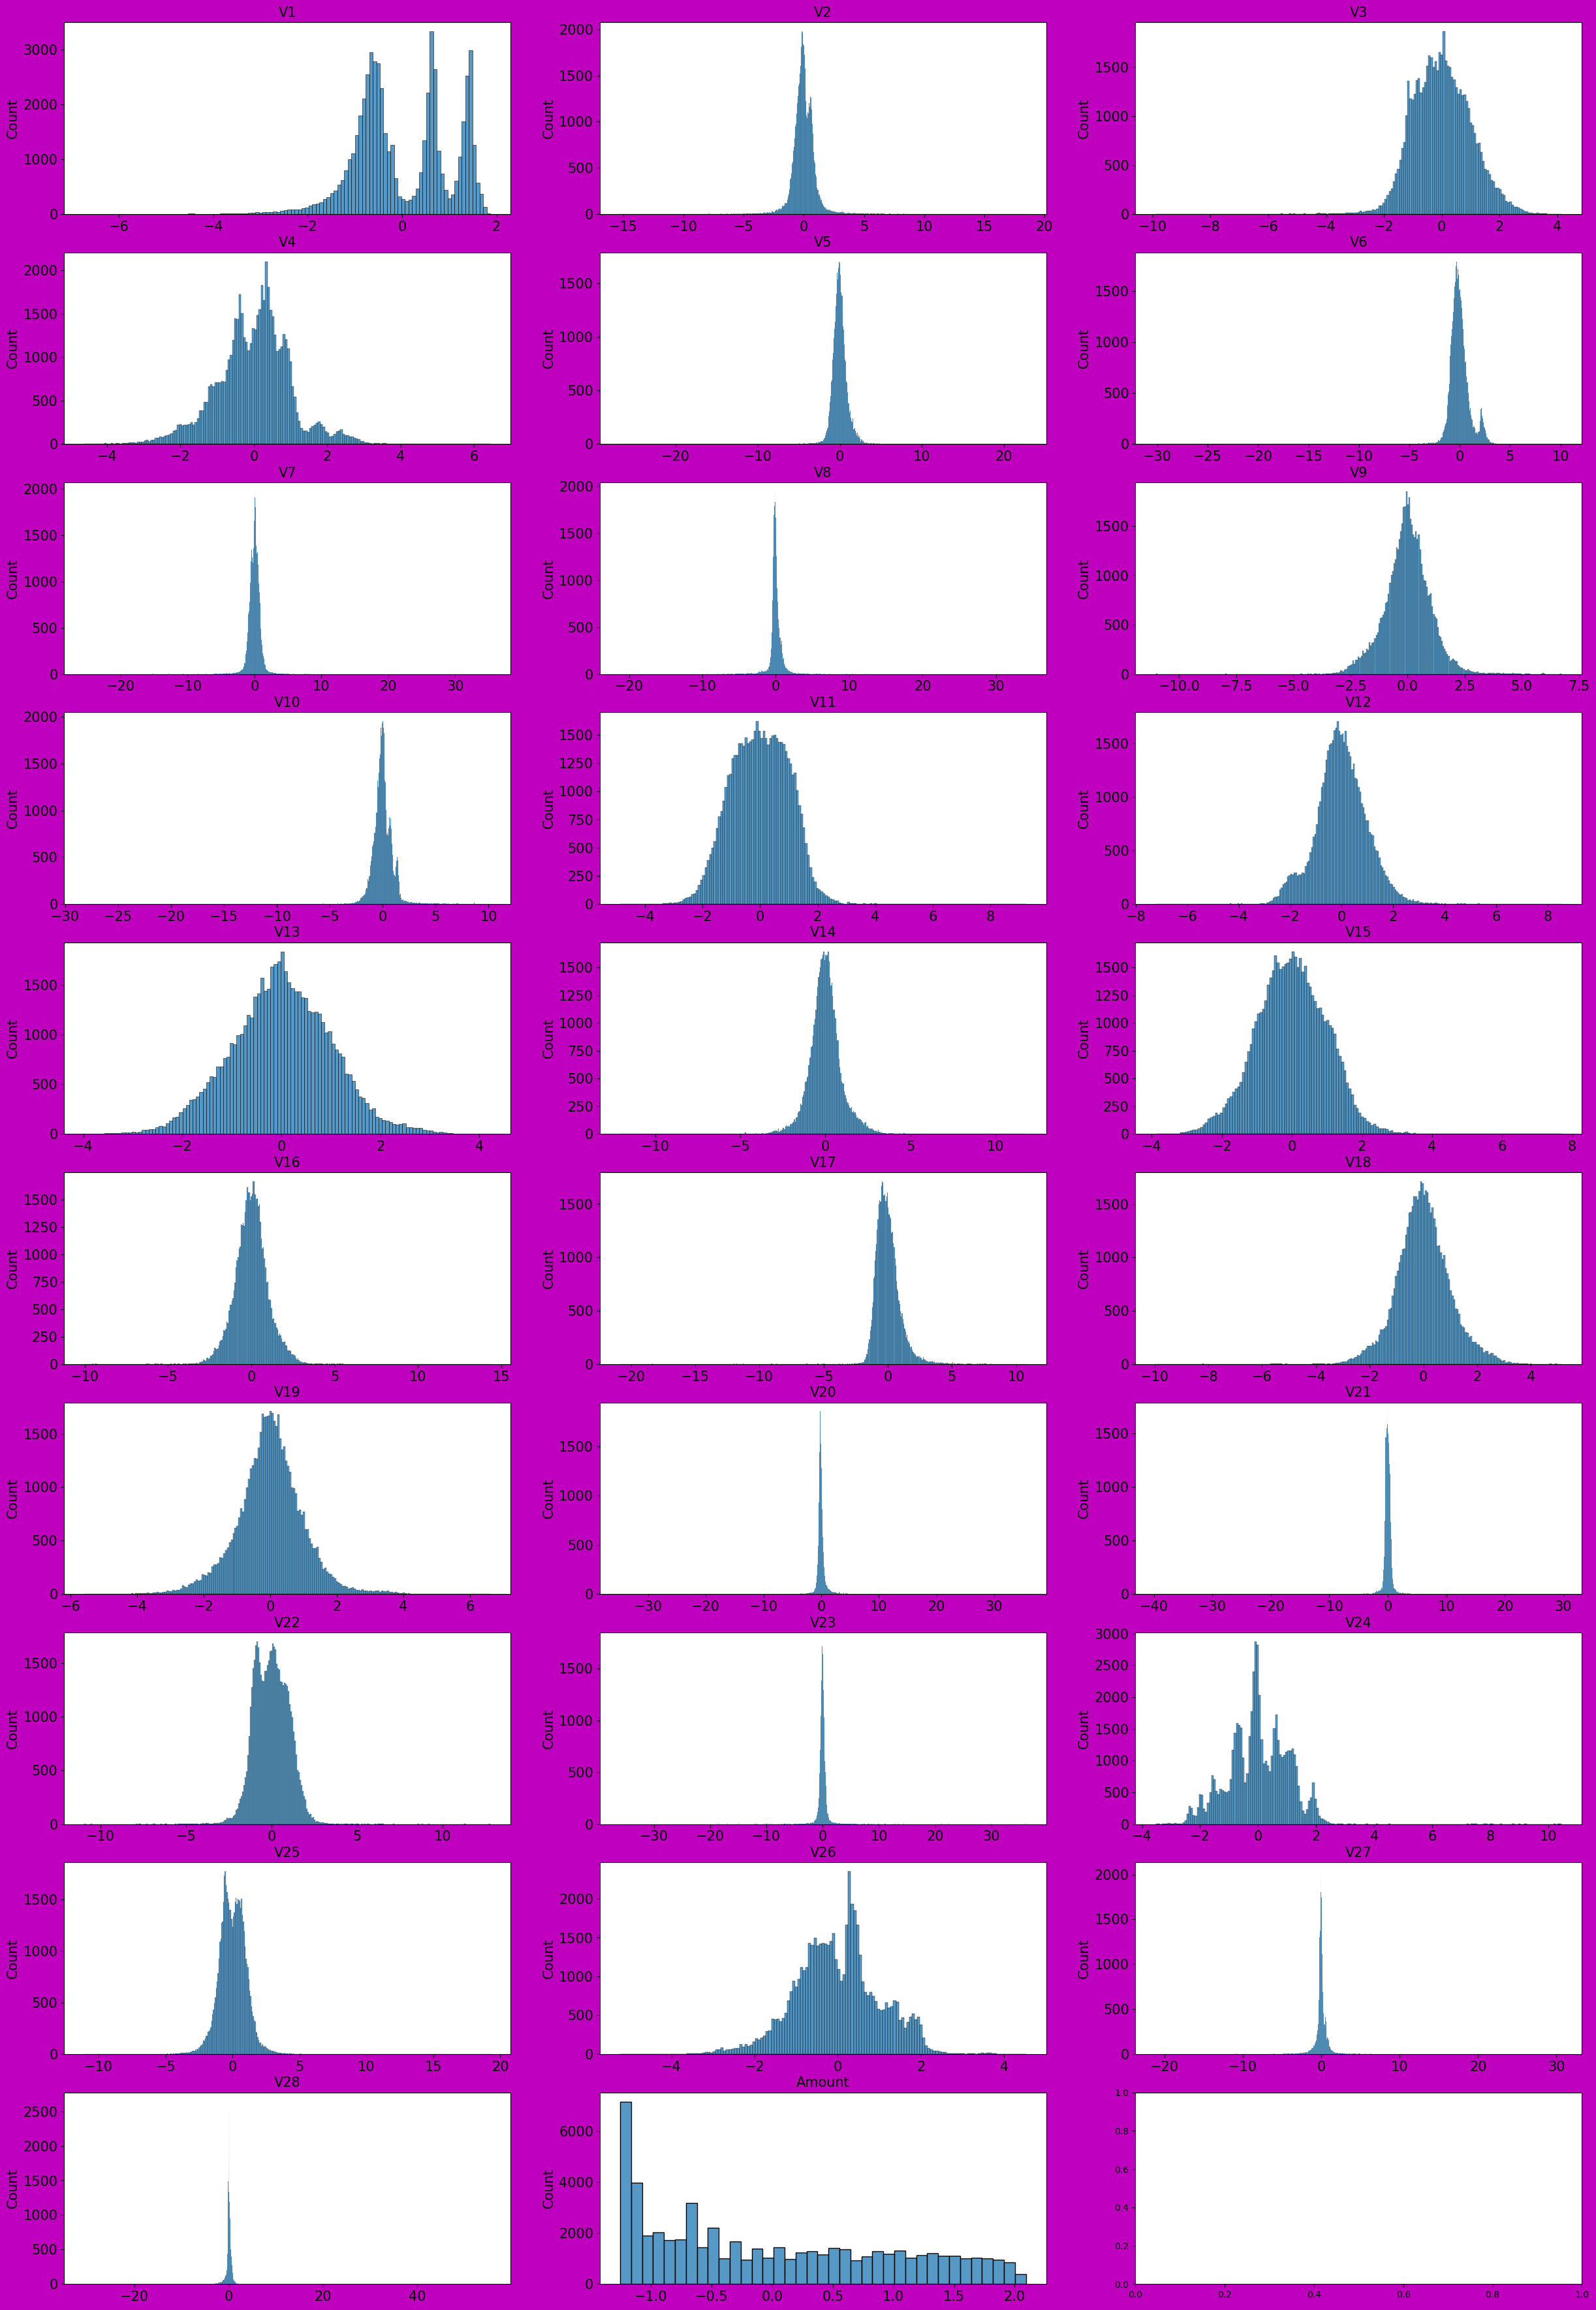

In [45]:
# Plot the histogram of a variable from the test dataset again to see the result after application of the PowerTransformer

# Create a list of all column names in the transformed test dataset
var = list(X_test.columns.values)

# Create a figure with 30 subplots (10 rows, 3 columns), with specified size and background color
fig, axes = plt.subplots(10, 3, figsize=(30, 45), facecolor='m')
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate over each feature and corresponding subplot axis
for i, ax in enumerate(axes):
    if i < len(var):
        sns.histplot(X_test[var[i]], ax=ax) 
        ax.set_title(var[i], fontsize=15)  
        ax.set_ylabel("Count", fontsize=15) 
        ax.tick_params(axis='both', labelsize=15)  
        ax.set_xlabel('') 

# Display the plots
plt.show()


## Model Building
- Build different models on the imbalanced dataset and see the result

### Defining model functions for
1. Logistic regression
2. KNN
3. SVM
4. Decision Tree
5. Random Forest
6. XGBoost

In [47]:
# A dataframe to store all model results in place for better overview
df_Results = pd.DataFrame(columns=['Data_Imbalance_Handling','Model','Accuracy','Roc_Value','Threshold'])

In [48]:
# Function to plot confusion matrix
def Plot_confusion_matrix(y_test, y_test_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Clear the plot
    plt.clf()

    # Set the figure size
    plt.rcParams["figure.figsize"] = (5,5)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap="Blues")

    # Define class names
    classNames = ['Non-Fraudulent', 'Fraudulent']

    # Add title and labels
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Set ticks
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    # Add text annotations
    labels = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f'{labels[i][j]} = {cm[i][j]}', fontsize=10, ha='center', va='center')

    # Show the plot
    plt.show()


In [49]:
# ROC Curve function

def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs)
    auc_score = metrics.roc_auc_score(actual, probs)

    # Determine the optimal threshold by maximizing the difference between TPR and FPR
    threshold = thresholds[np.argmax(tpr - fpr)]

    # Print the AUC score and the optimal threshold
    print("-" * 100)
    print("ROC       :", '{:.1%}'.format(round(auc_score,4)))
    print("Threshold :", threshold)
    print("-" * 100)

    # Set the size of the plot
    plt.rcParams["figure.figsize"] = (5, 5)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % round(auc_score,4))

    # Plot the diagonal line (no skill line)
    plt.plot([0, 1], [0, 1], 'k--')

    # Set the x and y axis limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Set the x and y axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set the title of the plot
    plt.title('ROC AUC - Test Data')

    # Add a legend to the plot
    plt.legend(loc=4)

    # Display the plot
    plt.show()

    # Return the AUC score and the optimal threshold
    return round(auc_score,4), threshold


In [50]:
def LogisticRegressionWithL1PipeLine(df_Results, DataImbalance, X_train, y_train, X_test, y_test):
    # Generate a list of values for the regularization parameter 'C'
    num_C = list(np.power(10.0, np.arange(-10, 10)))

    # Set up cross-validation with 5 folds, shuffling the data, and using a fixed random state
    cv_num = KFold(n_splits=5, shuffle=True, random_state=42)

    # Set up Logistic Regression with L1 regularization using cross-validation
    searchCV_l1 = linear_model.LogisticRegressionCV(
        Cs=num_C,
        penalty='l1',
        scoring='roc_auc',
        cv=cv_num,
        random_state=42,
        max_iter=10000,
        fit_intercept=True,
        solver='liblinear',
        tol=10
    )

    # Fit the model to the training data
    searchCV_l1.fit(X_train, y_train)

    # Print the maximum AUC ROC score for L1 regularization
    print('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())
    print("-" * 100)

    # Print the parameters for L1 regularization
    print("Parameters for l1 regularisations")
    print(searchCV_l1.coef_)
    print(searchCV_l1.intercept_)
    print(searchCV_l1.scores_)

    # Find the predicted values for the test set
    y_pred_l1 = searchCV_l1.predict(X_test)

    # Find the predicted probabilities for the test set
    y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:, 1]

    # Calculate the accuracy of the model
    Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)
    print("-" * 100)
    print("Accuracy of Logistic model with L1 regularisation: {0}".format(round(Accuracy_l1,4)))
    print("-" * 100)

    # Print the confusion matrix
    print("\nConfusion Matrix")
    Plot_confusion_matrix(y_test, y_pred_l1)

    # Print the classification report
    print("\nClassification Report")
    print("-" * 100)
    print(classification_report(y_test, y_pred_l1))

    # Generate the ROC curve and find the ROC value and threshold
    l1_roc_value, threshold = draw_roc(y_test, y_pred_probs_l1)

    # Append the results to the DataFrame
    df_Results = pd.concat([df_Results, pd.DataFrame({
        'Data_Imbalance_Handling': DataImbalance,
        'Model': 'Logistic Regression with L1 Regularisation',
        'Accuracy': round(Accuracy_l1,4),
        'Roc_Value': l1_roc_value,
        'Threshold': threshold
    }, index=[0])], ignore_index=True)

    # Return the updated DataFrame with results
    return df_Results


In [51]:
def LogisticRegressionWithL2PipeLine(df_Results, DataImbalance, X_train, y_train, X_test, y_test):
    # Generate a list of values for the regularization parameter 'C'
    num_C = list(np.power(10.0, np.arange(-10, 10)))

    # Set up cross-validation with 5 folds, shuffling the data, and using a fixed random state
    cv_num = KFold(n_splits=5, shuffle=True, random_state=42)

    # Set up Logistic Regression with L2 regularization using cross-validation
    searchCV_l2 = linear_model.LogisticRegressionCV(
        Cs=num_C,
        penalty='l2',
        scoring='roc_auc',
        cv=cv_num,
        random_state=42,
        max_iter=10000,
        fit_intercept=True,
        solver='liblinear',
        tol=10
    )

    # Fit the model to the training data
    searchCV_l2.fit(X_train, y_train)

    # Print the maximum AUC ROC score for L2 regularization
    print('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())
    print("-" * 100)

    # Print the parameters for L2 regularization
    print("Parameters for l2 regularisations")
    print(searchCV_l2.coef_)
    print(searchCV_l2.intercept_)
    print(searchCV_l2.scores_)

    # Find the predicted values for the test set
    y_pred_l2 = searchCV_l2.predict(X_test)

    # Find the predicted probabilities for the test set
    y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:, 1]

    # Calculate the accuracy of the model
    Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
    print("-" * 100)
    print("Accuracy of Logistic model with l2 regularisation: {0}".format(round(Accuracy_l2,4)))
    print("-" * 100)

    # Print the confusion matrix
    print("\nConfusion Matrix")
    Plot_confusion_matrix(y_test, y_pred_l2)

    # Print the classification report
    print("\nClassification Report")
    print("-" * 100)
    print(classification_report(y_test, y_pred_l2))

    # Generate the ROC curve and find the ROC value and threshold
    l2_roc_value, threshold = draw_roc(y_test, y_pred_probs_l2)

    # Append the results to the DataFrame
    df_Results = pd.concat([df_Results, pd.DataFrame({
        'Data_Imbalance_Handling': DataImbalance,
        'Model': 'Logistic Regression with L2 Regularisation',
        'Accuracy': round(Accuracy_l2,4),
        'Roc_Value': l2_roc_value,
        'Threshold': threshold
    }, index=[0])], ignore_index=True)

    # Return the updated DataFrame with results
    return df_Results


#### Defining KNN

In [53]:
def KNNPipeLine(df_Results, DataImbalance, X_train, y_train, X_test, y_test):

    # Create KNN model and fit the model with the training dataset
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=2)
    knn.fit(X_train, y_train)

    # Predict the labels for the test dataset
    y_pred = knn.predict(X_test)

    # Calculate the accuracy of the KNN model
    KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Accuracy of KNN model: {0}".format(round(KNN_Accuracy,4)))
    print("-" * 100)

    # Print the confusion matrix
    print("\nConfusion Matrix")
    Plot_confusion_matrix(y_test, y_pred)

    # Print the classification report
    print("\nClassification Report")
    print("-" * 100)
    print(classification_report(y_test, y_pred))

    # Find the predicted probabilities for the test dataset
    knn_probs = knn.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC value and threshold using the ROC curve
    knn_roc_value, threshold = draw_roc(y_test, knn_probs)

    # Append the results to the DataFrame
    df_Results = pd.concat([df_Results, pd.DataFrame({
        'Data_Imbalance_Handling': DataImbalance,
        'Model': 'KNN',
        'Accuracy': round(KNN_Accuracy,4),
        'Roc_Value': knn_roc_value,
        'Threshold': threshold
    }, index=[0])], ignore_index=True)

    # Return the updated DataFrame with results
    return df_Results


### Defining SVM Model

In [55]:
def SVMPipeLine(df_Results, DataImbalance, X_train, y_train, X_test, y_test):
    # Initialize SVM model with sigmoid kernel and specified random state
    SVModel = SVC(kernel='sigmoid', random_state=42, probability=True)

    # Fit the model on the training data
    SVModel.fit(X_train, y_train)

    # Predict the labels for the test data
    y_pred_SVM = SVModel.predict(X_test)

    # Calculate accuracy score for the predictions
    SVM_Score = accuracy_score(y_test, y_pred_SVM)
    print("SVM Accuracy Score: {0}".format(round(SVM_Score,4)))
    print("-" * 100)

    # Print confusion matrix for the predictions
    print("\nConfusion Matrix")
    Plot_confusion_matrix(y_test, y_pred_SVM)

    # Print classification report for the predictions
    print("\nClassification Report")
    print("-" * 100)
    print(classification_report(y_test, y_pred_SVM))

    # Calculate ROC AUC value and threshold using the predicted probabilities
    svm_probs = SVModel.predict_proba(X_test)[:, 1]
    svm_roc_value, threshold = draw_roc(y_test, svm_probs)

    # Update the results dataframe with the new metrics
    df_Results = pd.concat([df_Results, pd.DataFrame({
        'Data_Imbalance_Handling': DataImbalance,
        'Model': 'SVM',
        'Accuracy': round(SVM_Score,4),
        'Roc_Value': svm_roc_value,
        'Threshold': threshold
    }, index=[0])], ignore_index=True)

    return df_Results

### Defining Decision Tree

In [57]:
def DecisionTreePipeLine(df_Results, DataImbalance, X_train, y_train, X_test, y_test):
    # Evaluate Decision Tree model with 'gini' and 'entropy' criteria
    criteria = ['gini', 'entropy']
    scores = {}

    for c in criteria:
        # Initialize Decision Tree model with the specified criterion
        dt = DecisionTreeClassifier(criterion=c, random_state=42)

        # Fit the model on the training data
        dt.fit(X_train, y_train)

        # Predict the labels for the test data
        y_pred = dt.predict(X_test)

        # Calculate the accuracy score for the predictions
        test_score = dt.score(X_test, y_test)

        # Predict probabilities for the test data
        tree_preds = dt.predict_proba(X_test)[:, 1]

        # Print the accuracy score for the current criterion
        print('Decision Tree with ' + c + " Accuracy: {0}".format(test_score))
        print("-" * 100)

        print("\nConfusion Matrix")
        Plot_confusion_matrix(y_test, y_pred)

        print("\nClassification Report")
        print("-" * 100)
        print(classification_report(y_test, y_pred))

        tree_roc_value, threshold = draw_roc(y_test, tree_preds)

        df_Results = pd.concat([df_Results, pd.DataFrame({
            'Data_Imbalance_Handling': DataImbalance,
            'Model': 'Tree Model with {0} criteria'.format(c),
            'Accuracy': test_score,
            'Roc_Value': tree_roc_value,
            'Threshold': threshold
        }, index=[0])], ignore_index=True)

    return df_Results


### Defining Random Forest

In [59]:
def RandomForestPipeLine(df_Results, DataImbalance, X_train, y_train, X_test, y_test):
    # Initialize the Random Forest model with 100 trees
    RF_model = RandomForestClassifier(n_estimators=100,
                                      bootstrap=True,
                                      max_features='sqrt',
                                      n_jobs= -1,
                                      random_state=42)

    # Fit the model on the training data
    RF_model.fit(X_train, y_train)
    # Score the model on the test data
    RF_test_score = RF_model.score(X_test, y_test)
    RF_test_score = round(RF_test_score,4)
    print('Random Forest Model Accuracy: {0}'.format(RF_test_score))
    print("-" * 100)

    # Make predictions on the test data
    rf_predictions = RF_model.predict(X_test)
    print("\nConfusion Matrix")
    Plot_confusion_matrix(y_test, rf_predictions)
    print("\nClassification Report")
    print("-" * 100)
    print(classification_report(y_test, rf_predictions))

    # Get probability scores for each class
    rf_probs = RF_model.predict_proba(X_test)[:, 1]
    rf_roc_value, threshold = draw_roc(y_test, rf_probs)

    df_Results = pd.concat([df_Results, pd.DataFrame({
        'Data_Imbalance_Handling': DataImbalance,
        'Model': 'Random Forest',
        'Accuracy': RF_test_score,
        'Roc_Value': rf_roc_value,
        'Threshold': threshold
    }, index=[0])], ignore_index=True)

    # Return the updated results dataframe
    return df_Results

### Defining XGBoost

In [61]:
def XGBoostPipeLine(df_Results, DataImbalance, X_train, y_train, X_test, y_test):
    # Initialize the XGBoost model with a fixed random state for reproducibility
    XGBmodel = XGBClassifier(random_state=42)

    # Fit the model on the training data
    XGBmodel.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = XGBmodel.predict(X_test)

    # Calculate and print the model's accuracy score on the test data
    XGB_test_score = XGBmodel.score(X_test, y_test)
    XGB_test_score=round(XGB_test_score,4)
    print('XGBoost Model Accuracy: {0}'.format(XGB_test_score))
    print("-" * 100)

    # Print and plot the confusion matrix
    print("\nConfusion Matrix")
    Plot_confusion_matrix(y_test, y_pred)

    # Print the classification report
    print("\nClassification Report")
    print("-" * 100)
    print(classification_report(y_test, y_pred))

    # Calculate the probabilities for each class
    XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

    # Calculate and plot the ROC curve and get the ROC AUC value and threshold
    XGB_roc_value, threshold = draw_roc(y_test, XGB_probs)

    # Append the results to the DataFrame 'df_Results'
    df_Results = pd.concat([df_Results, pd.DataFrame({
        'Data_Imbalance_Handling': DataImbalance,
        'Model': 'XGBoost',
        'Accuracy': XGB_test_score,
        'Roc_Value': XGB_roc_value,
        'Threshold': threshold
        }, index=[0])], ignore_index=True)

    # Return the updated DataFrame with results
    return df_Results


#### Executing all model pipelines on the imbalanced data

Logistic Regression with L1 Regularisation
Max auc_roc for l1: 0.982137583405307
----------------------------------------------------------------------------------------------------
Parameters for l1 regularisations
[[-0.0964569   0.09976204 -0.24260125  0.4664827   0.05281573 -0.02343027
  -0.07240991 -0.22748018 -0.11403928 -0.22206224  0.33235362 -0.32382834
  -0.04967742 -0.44982431 -0.05947625 -0.09767424 -0.14601512 -0.02070568
  -0.07787326 -0.01316208  0.04628624  0.0591106  -0.05091674 -0.02223569
   0.00481324  0.00403166 -0.00561562 -0.01003909  0.07921435]]
[-6.82975681]
{1: array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.91651218, 0.96402374, 0.9694732 ,
        0.97024306, 0.96865066, 0.98044775, 0.98192541, 0.97467509,
        0.97190107, 0.96431074, 0.96846385, 0.97027053, 0.9730397 ],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.89882086, 0.95214703, 0.9578265

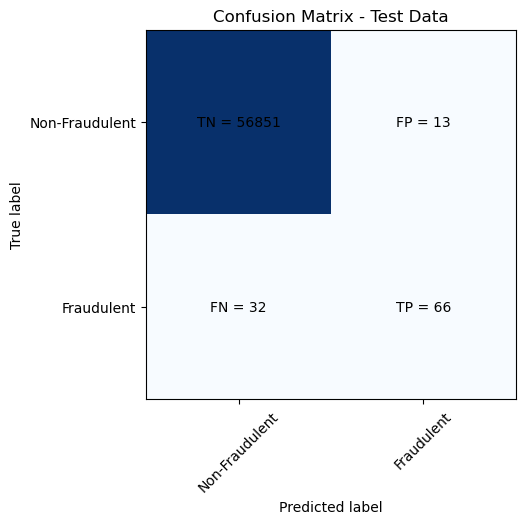


Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.67      0.75        98

    accuracy                           1.00     56962
   macro avg       0.92      0.84      0.87     56962
weighted avg       1.00      1.00      1.00     56962

----------------------------------------------------------------------------------------------------
ROC       : 97.9%
Threshold : 0.0038105257306300182
----------------------------------------------------------------------------------------------------


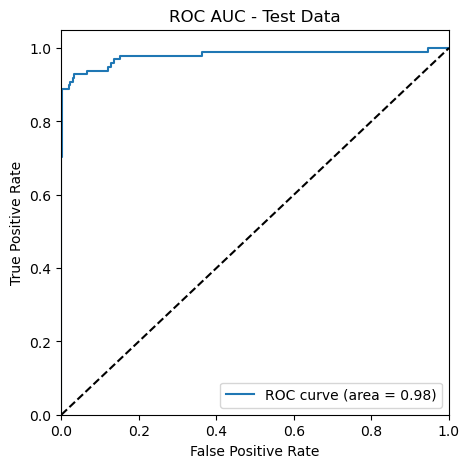

____________________________________________________________________________________________________
⏱ Time Taken by Model: 26 seconds


In [63]:
#Logistic Regression with L1 Regularisation for Imbalanced data
print("Logistic Regression with L1 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL1PipeLine(df_Results,"Power Transformer",X_train,y_train, X_test, y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


Logistic Regression with L2 Regularisation
Max auc_roc for l2: 0.9763398051512207
----------------------------------------------------------------------------------------------------
Parameters for l2 regularisations
[[-0.05599532  0.05631822 -0.14033634  0.14246952 -0.02370914 -0.03462233
  -0.10482192 -0.04737221 -0.08138432 -0.18218466  0.13927257 -0.18829951
  -0.00930555 -0.25737344 -0.01448339 -0.11530598 -0.15062979 -0.03947381
   0.00241579  0.0009305   0.02766186  0.01025271 -0.00893597 -0.01682219
  -0.00154968  0.00393785  0.00348536  0.00527874  0.00843236]]
[-5.13727784]
{1: array([[0.91660914, 0.91660914, 0.91660914, 0.91660914, 0.91660914,
        0.91660914, 0.93950327, 0.96587147, 0.96955238, 0.96959731,
        0.96959989, 0.96960054, 0.96960054, 0.96960054, 0.96960054,
        0.96960054, 0.96960054, 0.96960054, 0.96960054, 0.96960054],
       [0.85946784, 0.85946784, 0.85946784, 0.85946784, 0.85946784,
        0.85946784, 0.88804512, 0.94135205, 0.95520645, 0.955574

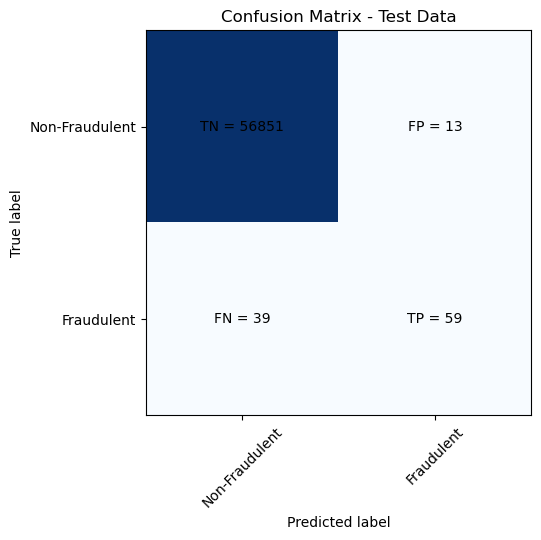


Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.60      0.69        98

    accuracy                           1.00     56962
   macro avg       0.91      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

----------------------------------------------------------------------------------------------------
ROC       : 97.4%
Threshold : 0.011896666834895013
----------------------------------------------------------------------------------------------------


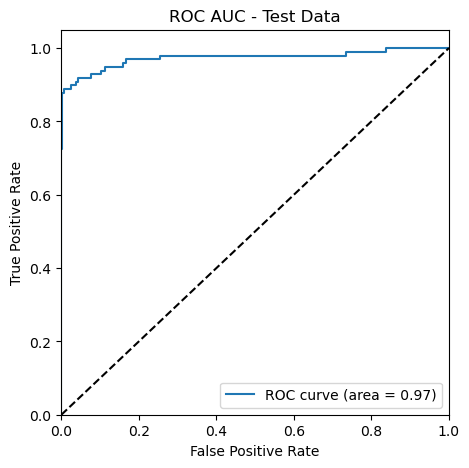

____________________________________________________________________________________________________
⏱ Time Taken by Model: 22 seconds


In [64]:
#Logistic Regression with L2 Regularisation for Imbalanced data
print("Logistic Regression with L2 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL2PipeLine(df_Results,"Power Transformer",X_train,y_train, X_test, y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")



### Observation : Logistic Regression with L1 and L2 show best Roc value.

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

KNN Model
Accuracy of KNN model: 0.9995
----------------------------------------------------------------------------------------------------

Confusion Matrix


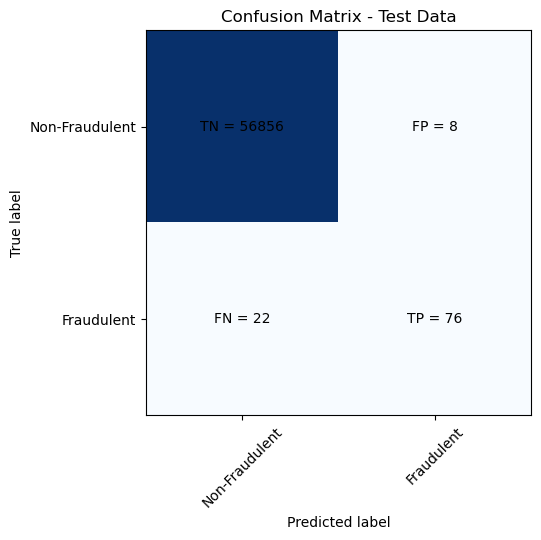


Classification Report
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.78      0.84        98

    accuracy                           1.00     56962
   macro avg       0.95      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# KNN Model for Imbalanced data
print("KNN Model")
print('='*100 )
start_time = time.time()
df_Results = KNNPipeLine(df_Results,"Power Transformer",X_train,y_train, X_test, y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
#SVM Model with Sigmoid Kernel for Imbalanced data
print("SVM Model with Sigmoid Kernel")
print('='*100 )
start_time = time.time()
df_Results = SVMPipeLine(df_Results,"Power Transformer",X_train,y_train,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# Decision Tree Models with  'gini' & 'entropy' criteria for Imbalanced data
print("Decision Tree Models with  'gini' & 'entropy' criteria")
print('='*100 )
start_time = time.time()
df_Results = DecisionTreePipeLine(df_Results,"Power Transformer",X_train,y_train,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# Random Forest Model for Imbalanced data
print("Random Forest Model")
print('='*100 )
start_time = time.time()
df_Results = RandomForestPipeLine(df_Results,"Power Transformer",X_train,y_train,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# XGBoost Model for Imbalanced data
print("XGBoost Model")
print('='*100 )
start_time = time.time()
df_Results = XGBoostPipeLine(df_Results,"Power Transformer",X_train,y_train,X_test,y_test)
print('='*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# Checking all the results created so far
df_Results

In [ ]:
# Sorting the results of all model on imbalanced data where we applied power transformer
df_Results[df_Results['Data_Imbalance_Handling']=='Power Transformer'].sort_values(by='Roc_Value',ascending=False)

### Observation : 
Logistic Regression with L1 and L2 show best Roc value.

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

### Perform cross validation with RepeatedKFold

In [ ]:
# Let's perform RepeatedKFold and check the results

# Initialize RepeatedKFold with 5 splits and 10 repeats
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)

# X is the feature set and y is the target
for train_index, test_index in rkf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

# As PCA is already performed on the dataset from V1 to V28 features, we are scaling only Amount field which is in its raw form.
# Scaling the train data
X_train_cv[["Amount"]] = scaler.fit_transform(X_train_cv[["Amount"]])

# Transforming the test data
X_test_cv[["Amount"]] = scaler.transform(X_test_cv[["Amount"]])

In [ ]:
X_train_cv.shape,X_test_cv.shape

In [ ]:
# Checking the split of the class label in term of percentage
print("Fraudulent Percentage for Train data : ",np.sum(y_train_cv)/len(y_train_cv)*100)
print("Fraudulent Percentage for Test data  : ",np.sum(y_test_cv)/len(y_test_cv)*100)

In [ ]:
# Logistic Regression with L1 Regularisation for RepeatedKFold Imbalanced Data
print("Logistic Regression with L1 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL1PipeLine(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv,X_test_cv,y_test_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# Logistic Regression with L2 Regularisation for RepeatedKFold Imbalanced Data
print("Logistic Regression with L2 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL2PipeLine(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv,X_test_cv,y_test_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# KNN Model for RepeatedKFold Imbalanced Data
print("KNN Model")
print('='*100 )
start_time = time.time()
df_Results = KNNPipeLine(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv,X_test_cv,y_test_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
#SVM Model with Sigmoid Kernel  for RepeatedKFold Imbalanced Data
print("SVM Model with Sigmoid Kernel")
print('='*100 )
start_time = time.time()
df_Results = SVMPipeLine(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv,X_test_cv,y_test_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")



In [ ]:
# Decision Tree Models with  'gini' & 'entropy' criteria for RepeatedKFold Imbalanced Data
print("Decision Tree Models with  'gini' & 'entropy' criteria")
print('='*100 )
start_time = time.time()
df_Results = DecisionTreePipeLine(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv,X_test_cv,y_test_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# Random Forest Model for RepeatedKFold Imbalanced Data
print("Random Forest Model")
print('='*100 )
start_time = time.time()
df_Results = RandomForestPipeLine(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv,X_test_cv,y_test_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# XGBoost Model for RepeatedKFold Imbalanced Data
print("XGBoost Model")
print('='*100 )
start_time = time.time()
df_Results = XGBoostPipeLine(df_Results,"RepeatedKFold Cross Validation",X_train_cv,y_train_cv,X_test_cv,y_test_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


### Observation : On RepeatedKFold cross validation data, XGBoost has the best roc value.


In [ ]:
# Sorting the results of all model done so far
df_Results.sort_values(by='Roc_Value',ascending=False)

### Observation: XGBoost on RepeatedKFold Cross Validation has the overall best roc value.


### Perform cross validation with StratifiedKFold on Imbalanced Data

In [ ]:
# Let's perform StratifiedKFold and check the results

# Initialize StratifiedKFold with 10 splits
skf = StratifiedKFold(n_splits=10, random_state=None)

# X is the feature set and y is the target
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

# As PCA is already performed on the dataset from V1 to V28 features, we are scaling only Amount field which is in its raw form.
# Scaling the train data
X_train_SKF_cv[["Amount"]] = scaler.fit_transform(X_train_SKF_cv[["Amount"]])

# Transforming the test data
X_test_SKF_cv[["Amount"]] = scaler.transform(X_test_SKF_cv[["Amount"]])

In [ ]:
# Checking the split of the class label in term of percentage
print("Fraudulent Percentage for Train data : ",np.sum(y_train_SKF_cv)/len(y_train_SKF_cv)*100)
print("Fraudulent Percentage for Test data  : ",np.sum(y_test_SKF_cv)/len(y_test_SKF_cv)*100)

In [ ]:
# Logistic Regression with L1 Regularisation for StratifiedKFold Cross Validation Imbalanced Data
print("Logistic Regression with L1 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL1PipeLine(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Logistic Regression with L2 Regularisation for StratifiedKFold Cross Validation Imbalanced Data
print("Logistic Regression with L2 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL2PipeLine(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# KNN Model for StratifiedKFold Cross Validation Imbalanced Data
print("KNN Model")
print('='*100 )
start_time = time.time()
df_Results = KNNPipeLine(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
#SVM Model with Sigmoid Kernel for StratifiedKFold Cross Validation Imbalanced Data
print("SVM Model with Sigmoid Kernel")
print('='*100 )
start_time = time.time()
df_Results = SVMPipeLine(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Decision Tree Models with  'gini' & 'entropy' criteria  for StratifiedKFold Cross Validation Imbalanced Data
print("Decision Tree Models with  'gini' & 'entropy' criteria")
print('='*100 )
start_time = time.time()
df_Results = DecisionTreePipeLine(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Random Forest Model for StratifiedKFold Cross Validation Imbalanced Data
print("Random Forest Model")
print('='*100 )
start_time = time.time()
df_Results = RandomForestPipeLine(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# XGBoost Model  for StratifiedKFold Cross Validation Imbalanced Data
print("XGBoost Model")
print('='*100 )
start_time = time.time()
df_Results = XGBoostPipeLine(df_Results,"StratifiedKFold Cross Validation",X_train_SKF_cv,y_train_SKF_cv,X_test_SKF_cv,y_test_SKF_cv)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# Sorting the results of all model on imbalanced data where we applied StratifiedKFold Cross Validation
df_Results[df_Results['Data_Imbalance_Handling']=='StratifiedKFold Cross Validation'].sort_values(by='Roc_Value',ascending=False)

In [ ]:
# Sorting the results of all model done so far
df_Results.sort_values(by='Roc_Value',ascending=False)

### Observation : XGBoost on RepeatedKFold Cross Validation has the overall best roc value.


### Using Undersampling methods

In [ ]:
# Instantiate Undersampler

# List the column names of the training features
cols = list(X_train.columns.values)

# Initialize the RandomUnderSampler with a sampling strategy of 0.5
RUS = RandomUnderSampler(sampling_strategy=0.5)

# Apply the undersampling to the training data
X_Under, y_Under = RUS.fit_resample(X_train, y_train)

# Create DataFrame for the undersampled features
X_Under = pd.DataFrame(data=X_Under, columns=cols)

In [ ]:
X_Under.shape,y_Under.shape

In [ ]:
# Checking the split of the class label in term of percentage
print("Fraudulent Percentage for Train data : ",np.sum(y_Under)/len(y_Under)*100)
print("Fraudulent Percentage for Test data  : ",np.sum(y_test)/len(y_test)*100)

### Observation : Due to undersampling, we can see that % of fraudulent has increased in train data compared to test data.

In [ ]:
Data_Imbalance_Handling = "Random Undersampling"

In [ ]:
# Logistic Regression with L1 Regularisation for Random Undersampling data
print("Logistic Regression with L1 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL1PipeLine(df_Results,Data_Imbalance_Handling,X_Under,y_Under,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Logistic Regression with L2 Regularisation  for Random Undersampling data
print("Logistic Regression with L2 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL2PipeLine(df_Results,Data_Imbalance_Handling,X_Under,y_Under,X_test,y_test)
print('_'*100 )


In [ ]:
# KNN Model for Random Undersampling data
print("KNN Model")
print('='*100 )
start_time = time.time()
df_Results = KNNPipeLine(df_Results,Data_Imbalance_Handling,X_Under,y_Under,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
#SVM Model with Sigmoid Kernel  for Random Undersampling data
print("SVM Model with Sigmoid Kernel")
print('='*100 )
start_time = time.time()
df_Results = SVMPipeLine(df_Results,Data_Imbalance_Handling,X_Under,y_Under,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Decision Tree Models with  'gini' & 'entropy' criteria  for Random Undersampling data
print("Decision Tree Models with  'gini' & 'entropy' criteria")
print('='*100 )
start_time = time.time()
df_Results = DecisionTreePipeLine(df_Results,Data_Imbalance_Handling,X_Under,y_Under,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Random Forest Model  for Random Undersampling data
print("Random Forest Model")
print('='*100 )
start_time = time.time()
df_Results = RandomForestPipeLine(df_Results,Data_Imbalance_Handling,X_Under,y_Under,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# XGBoost Model for Random Undersampling data
print("XGBoost Model")
print('='*100 )
start_time = time.time()
df_Results = XGBoostPipeLine(df_Results,Data_Imbalance_Handling,X_Under,y_Under,X_test,y_test)


In [ ]:
# Sorting the results of all model, where we used Random Undersampling
df_Results[df_Results['Data_Imbalance_Handling']=='Random Undersampling'].sort_values(by='Roc_Value',ascending=False)

In [ ]:
# Sorting the results of all model done so far
df_Results.sort_values(by='Roc_Value',ascending=False)

### Observation : On Random  Undersampling, XGBoost has best roc value. Logistic Regression is not doing well

### Observation : XGBoost on RepeatedKFold Cross Validation has the overall best roc value so far.

## Model building with balancing Classes

**Why is Accuracy Not Suitable for Imbalanced Datasets?**

* Accuracy is not an ideal metric for imbalanced datasets.

* In such cases, a model might achieve a high accuracy score by correctly predicting the majority of observations, but this can be misleading as it fails to capture the poor performance of the model on the minority class.

* Instead of accuracy, consider using ROC AUC, which provide a more comprehensive evaluation of the model's performance across all classification thresholds.

**Undersampling:** Involves selecting fewer data points from the majority class to balance the classes during model training.

**Oversampling:** Involves assigning weights to randomly chosen data points from the minority class, allowing the algorithm to focus more on this class while optimizing the loss function.

**SMOTE (Synthetic Minority Over-sampling Technique):** Generates new data points that lie between two data points of the minority class.

**ADASYN (Adaptive Synthetic Sampling):** Similar to SMOTE, but focuses on generating synthetic data for minority examples that are harder to learn, ensuring a density distribution.

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

### Random Oversampling

In [ ]:
# List the column names of the features
cols = list(X_train.columns.values)

# Initialize RandomOverSampler with a sampling strategy of 0.5
ROS = RandomOverSampler(sampling_strategy=0.5)

# Apply the oversampling to the training data
X_over, y_over = ROS.fit_resample(X_train, y_train)

# Create DataFrame for the oversampled features
X_over = pd.DataFrame(data=X_over, columns=cols)

In [ ]:
# Checking the split of the class label
print("Fraudulent Count for Full data  : ",np.sum(y))
print("Fraudulent Count for Train data : ",np.sum(y_over))
print("Fraudulent Count for Test data  : ",np.sum(y_test))

In [ ]:
# Checking the split of the class label in term of percentage
print("Fraudulent Percentage for Train data : ",np.sum(y_over)/len(y_over)*100)
print("Fraudulent Percentage for Test data  : ",np.sum(y_test)/len(y_test)*100)

### Observation : Due oversampling, we can see that Fraudulent Percentage for Train data is higher.

In [ ]:
Data_Imbalance_Handling = "Random Oversampling"

In [ ]:
# Logistic Regression with L1 Regularisation for Balanced Data with Random Oversampling
print("Logistic Regression with L1 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL1PipeLine(df_Results,Data_Imbalance_Handling,X_over,y_over,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Logistic Regression with L2 Regularisation for Balanced Data with Random Oversampling
print("Logistic Regression with L2 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL2PipeLine(df_Results,Data_Imbalance_Handling,X_over,y_over,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# KNN Model  for Balanced Data with Random Oversampling
print("KNN Model")
print('='*100 )
start_time = time.time()
df_Results = KNNPipeLine(df_Results,Data_Imbalance_Handling,X_over,y_over,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

### Observation : SVM (Support Vector Machine) models execution is taking quite a bit of time with balanced data. It is very difficult to complete 1 instance of execution. This is becoming bottleneck for completing this project and hence, we are not executing with balanced data.

In [ ]:
# Decision Tree Models with  'gini' & 'entropy' criteria for Balanced Data with Random Oversampling
print("Decision Tree Models with  'gini' & 'entropy' criteria")
print('='*100 )
start_time = time.time()
df_Results = DecisionTreePipeLine(df_Results,Data_Imbalance_Handling,X_over,y_over,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Random Forest Model for Balanced Data with Random Oversampling
print("Random Forest Model")
print('='*100 )
start_time = time.time()
df_Results = RandomForestPipeLine(df_Results,Data_Imbalance_Handling,X_over,y_over,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# XGBoost Model for Balanced Data with Random Oversampling
print("XGBoost Model")
print('='*100 )
start_time = time.time()
df_Results = XGBoostPipeLine(df_Results,Data_Imbalance_Handling,X_over,y_over,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Sorting the results of all model, where we used Random Oversampling
df_Results[df_Results['Data_Imbalance_Handling']=='Random Oversampling'].sort_values(by='Roc_Value',ascending=False)

### Observation : Again XGBoost has best roc value for random oversampling

In [ ]:
# Sorting the results of all model done so far
df_Results.sort_values(by='Roc_Value',ascending=False)

### Observation : XGBoost on RepeatedKFold Cross Validation has the overall best roc value so far.

## Applying SMOTE

### Print the class distribution after applying SMOTE

In [ ]:
# Initialize SMOTE with a random state of 0
sm = over_sampling.SMOTE(random_state=0)

# Apply SMOTE to the training data to create oversampled feature and target sets
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do:
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

# Convert the training data to NumPy arrays for specific class extraction
X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

# Set the figure size for the plot
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()

# Plot 1: Actual Class-1 Examples
plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

# Plot 2: Actual Class-1 and Artificial SMOTE Class-1 Examples
plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
X_train_smote_1_np = X_train_smote_1.to_numpy()
plt.scatter(X_train_smote_1_np[:X_train_1.shape[0], 0], X_train_smote_1_np[:X_train_1.shape[0], 1], label='Artificial SMOTE Class-1 Examples')
plt.legend()

# Plot 3: Actual Class-1 and Class-0 Examples
plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

#Create Dataframe
X_train_smote = pd.DataFrame(data=X_train_smote,columns=cols)

In [ ]:
Data_Imbalance_Handling = "SMOTE Oversampling"

In [ ]:
# Logistic Regression with L1 Regularisation for Balanced Data using SMOTE Technique
print("Logistic Regression with L1 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL1PipeLine(df_Results,Data_Imbalance_Handling,X_train_smote,y_train_smote,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Logistic Regression with L2 Regularisation  for Balanced Data using SMOTE Technique
print("Logistic Regression with L2 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL2PipeLine(df_Results,Data_Imbalance_Handling,X_train_smote,y_train_smote,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


In [ ]:
# KNN Model for Balanced Data using SMOTE Technique
print("KNN Model")
print('='*100 )
start_time = time.time()
df_Results = KNNPipeLine(df_Results,Data_Imbalance_Handling,X_train_smote,y_train_smote,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")


### Observation : SVM (Support Vector Machine) models execution is taking quite a bit of time with balanced data. It is very difficult to complete 1 instance of execution. This is becoming bottleneck for completing this project and hence, we are not executing with balanced data.

In [ ]:
# Decision Tree Models with  'gini' & 'entropy' criteria for Balanced Data using SMOTE Technique
print("Decision Tree Models with  'gini' & 'entropy' criteria")
print('='*100 )
start_time = time.time()
df_Results = DecisionTreePipeLine(df_Results,Data_Imbalance_Handling,X_train_smote,y_train_smote,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Random Forest Model for Balanced Data using SMOTE Technique
print("Random Forest Model")
print('='*100 )
start_time = time.time()
df_Results = RandomForestPipeLine(df_Results,Data_Imbalance_Handling,X_train_smote,y_train_smote,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# XGBoost Model for Balanced Data using SMOTE Technique
print("XGBoost Model")
print('='*100 )
start_time = time.time()
df_Results = XGBoostPipeLine(df_Results,Data_Imbalance_Handling,X_train_smote,y_train_smote,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Sorting the results of all model, where we used SMOTE Oversampling
df_Results[df_Results['Data_Imbalance_Handling']=='SMOTE Oversampling'].sort_values(by='Roc_Value',ascending=False)

### Observation : For SMOTE oversampling, XGBoost model is giving best roc value.

In [ ]:
# Sorting the results of all model done so far
df_Results.sort_values(by='Roc_Value',ascending=False)

### Observation : Top 5 to 6 results have XGBoost models.

## Applying ADASYN

### Print the class distribution after applying ADASYN

In [ ]:
# Instantiate ADASYN with random_state
ada = over_sampling.ADASYN(random_state=0)

# Fit and resample the training data using ADASYN
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)

# Artificial minority samples and corresponding minority labels from ADASYN are appended below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

# Get the actual samples of class 1 and class 0 from the original training data
X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

# Set figure size for plotting
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()

# Plot actual Class-1 examples in the first subplot
plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

# Plot actual and artificial Class-1 examples in the second subplot
plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
X_train_adasyn_1_np = X_train_adasyn_1.to_numpy()
plt.scatter(X_train_adasyn_1_np[:X_train_1.shape[0], 0], X_train_adasyn_1_np[:X_train_1.shape[0], 1], label='Artificial ADASYN Class-1 Examples')
plt.legend()

# Plot actual Class-1 and Class-0 examples in the third subplot
plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

#Create Dataframe for X_ADASYN
X_train_adasyn = pd.DataFrame(data=X_train_adasyn,columns=cols)

##### Build models on other algorithms to see the better performing on ADASYN

In [ ]:
Data_Imbalance_Handling = "ADASYN Oversampling"

In [ ]:
# Logistic Regression with L1 Regularisation for Balanced Data using ADASYN Oversampling
print("Logistic Regression with L1 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL1PipeLine(df_Results,Data_Imbalance_Handling,X_train_adasyn,y_train_adasyn,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# Logistic Regression with L2 Regularisation for Balanced Data using ADASYN Oversampling
print("Logistic Regression with L2 Regularisation")
print('='*100 )
start_time = time.time()
df_Results = LogisticRegressionWithL2PipeLine(df_Results,Data_Imbalance_Handling,X_train_adasyn,y_train_adasyn,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

In [ ]:
# KNN Model for Balanced Data using ADASYN Oversampling
print("KNN Model")
print('='*100 )
start_time = time.time()
df_Results = KNNPipeLine(df_Results,Data_Imbalance_Handling,X_train_adasyn,y_train_adasyn,X_test,y_test)
print('_'*100 )
elapsed = time.time() - start_time
print(f"⏱ Time Taken by Model: {round(elapsed)} seconds")

### Observation :  XGBoost on RepeatedKFold Cross Validation has the overall best roc value.



## Inference from all the modelling done so far :
1. We can see that among all the models we tried (Logistic Regression, XGBoost, Decision Tree, and Random Forest), almost all of them have performed well.
2. More specifically **Logistic regression and XGBoost** performed best in terms of ROC-AUC score.
3. Undersampling is not always preferred because it reduces the size of the majority class, potentially leading to loss of important information and decreased performance on the majority class. Hence, we do not prefer to move ahead with undersampling.
4. Selecting the oversampling method which shows the best result on a model. Accuracy is not a good metric for imbalanced datasets. Hence, only focusing on results of balanced data.
5. SVM model for balanced data is taking immense time and due to computational limitation, we did not execute for balanced data.

We will move ahead with tuning of model mentioned in the below table.

## Tuning XGboost Model on SMOTE Oversampling data

In [ ]:
# For XGBoost : Tuning the hyperparameter max_depth and min_child_weight

# Defining the hyper parameters
param_test = {
 'max_depth':range(3,15,3),
 'min_child_weight':range(2,8,3)
}

#Defining the model
xgb_model = XGBClassifier(
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=np.nan, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1,
              eval_metric='auc')

# Setting up the GridSearchCV
cv_search1 = GridSearchCV(
              estimator = xgb_model,
              param_grid = param_test,
              scoring='roc_auc',
              n_jobs=-1,
              verbose = 1,
              cv=5)

# Fit  the model
cv_search1.fit(X_train_smote, y_train_smote)

In [ ]:
# Converting the result to dataframe for better readability
cv_results = pd.DataFrame(cv_search1.cv_results_)

# Sort cv_results by rank_test_score to see best score on top
cv_results.sort_values(by=['rank_test_score'])

In [ ]:
# printing the best parameters and best score
cv_search1.best_params_, cv_search1.best_score_

In [ ]:
# define function to compare the current score and new score

def compare_score(new_score):
  global current_best_score # Declare current_best_score as global
  if current_best_score == new_score:
    print('Score is same')
  elif current_best_score < new_score:
    print('Current best score is {0}'.format(current_best_score))
    print('Score is improved')
    print('New score is {0}'.format(new_score))
    current_best_score = new_score
  else:
    print('New score is {0}'.format(new_score))
    print('Score is not improved')
    print('Current best score is {0}'.format(current_best_score))

In [ ]:
# Capturing best train score in current_best_score variable for further comparision
current_best_score = cv_search1.best_score_
current_best_score

In [ ]:
# For XGBoost : Retuning the hyperparameter max_depth = 12 and min_child_weight = 2
# In order to see if there are any best scenarios before and after

# Defining the hyper parameters
param_test = {
 'max_depth':range(11,14,1),
 'min_child_weight':range(1,4,1)
}

#Defining the model
xgb_model = XGBClassifier(
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=np.nan, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1,
              eval_metric='auc')

# Setting up the GridSearchCV
cv_search2 = GridSearchCV(
              estimator = xgb_model,
              param_grid = param_test,
              scoring='roc_auc',
              n_jobs=-1,
              verbose = 1,
              cv=5)

# Fit  the model
cv_search2.fit(X_train_smote, y_train_smote)

In [ ]:
# Converting the result to dataframe for better readability
cv_results = pd.DataFrame(cv_search2.cv_results_)

# Sort cv_results by rank_test_score to see best score on top
cv_results.sort_values(by=['rank_test_score'])

In [ ]:
# printing the best parameters and best score
cv_search2.best_params_, cv_search2.best_score_

In [ ]:
# Compare the current best score and new score
compare_score(cv_search2.best_score_)


In [ ]:
# For XGBoost : Tuning the hyperparameter n_estimators
# Defining the hyper parameters
param_test = {
 'n_estimators':range(50,210,50)
}

#Defining the model
xgb_model = XGBClassifier(
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=3, missing=np.nan, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1,
              eval_metric='auc')

# Setting up the GridSearchCV
cv_search3 = GridSearchCV(
              estimator = xgb_model,
              param_grid = param_test,
              scoring='roc_auc',
              n_jobs=-1,
              verbose = 1,
              cv=5)

# Fit  the model
cv_search3.fit(X_train_smote, y_train_smote)

In [ ]:
# Converting the result to dataframe for better readability
cv_results = pd.DataFrame(cv_search3.cv_results_)

# Sort cv_results by rank_test_score to see best score on top
cv_results.sort_values(by=['rank_test_score'])

In [ ]:
# printing the best parameters and best score
cv_search3.best_params_, cv_search3.best_score_

In [ ]:
# Compare the current best score and new score
compare_score(cv_search3.best_score_)

In [ ]:
# For XGBoost : Tuning the hyperparameter learning_rate
# Defining the hyper parameters to be tested in GridSearchCV
param_test = {
 'learning_rate':[0.01,0.1,0.125,0.25,0.5,0.8]
}

# Defining the XGBoost model with initial parameters
xgb_model = XGBClassifier(
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=3, missing=np.nan, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1,
              eval_metric='auc')

# Setting up the GridSearchCV to find the best value of learning_rate
cv_search4 = GridSearchCV(
              estimator = xgb_model,
              param_grid = param_test,
              scoring='roc_auc',
              n_jobs=-1,
              verbose = 1,
              cv=5)

# Fit the GridSearchCV to the data to find the optimal learning_rate value
# X_train_smote and y_train_smote are the training data
cv_search4.fit(X_train_smote, y_train_smote)

In [ ]:
# Converting the result to dataframe for better readability
cv_results = pd.DataFrame(cv_search4.cv_results_)

# Sort cv_results by rank_test_score to see best score on top
cv_results.sort_values(by=['rank_test_score'])

In [ ]:
# printing the best parameters and best score
cv_search4.best_params_, cv_search4.best_score_

In [ ]:
# Compare the current best score and new score
compare_score(cv_search4.best_score_)

In [ ]:
# For XGBoost : Tuning the hyperparameter subsample
# Defining the hyper parameters to be tested in GridSearchCV
param_test = {
 'subsample':[0.5,0.8,0.9,1]
}

# Defining the XGBoost model with initial parameters
xgb_model = XGBClassifier(
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=12,
              min_child_weight=3, missing=np.nan, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1,
              eval_metric='auc')

# Setting up the GridSearchCV to find the best value of subsample
cv_search5 = GridSearchCV(
              estimator = xgb_model,
              param_grid = param_test,
              scoring='roc_auc',
              n_jobs=-1,
              verbose = 1,
              cv=5)

# Fit the GridSearchCV to the data to find the optimal subsample value
cv_search5.fit(X_train_smote, y_train_smote)

In [ ]:
# Converting the result to dataframe for better readability
cv_results = pd.DataFrame(cv_search5.cv_results_)

# Sort cv_results by rank_test_score to see best score on top
cv_results.sort_values(by=['rank_test_score'])

In [ ]:
# printing the best parameters and best score
cv_search5.best_params_, cv_search5.best_score_

In [ ]:
# Compare the current best score and new score
compare_score(cv_search5.best_score_)

In [ ]:
#Evaluate XGboost model on train and test data

# Defining the XGBoost model with parameters tuned
clf = XGBClassifier(
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=12,
              min_child_weight=3, missing=np.nan, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1,
              eval_metric='auc')
# Fit the model
clf.fit(X_train_smote, y_train_smote)

# Find the accuracy
XGB_test_score = clf.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

# Predict the labels for the test dataset
y_pred = clf.predict(X_test)

# Probabilities for each class
XGB_probs = clf.predict_proba(X_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)

print("XGboost roc_value: {0}" .format(XGB_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))
f1_value = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1_value))
precision_value = precision_score(y_test, y_pred)
print("Precision Score: {0}".format(precision_value))
recall_value = recall_score(y_test, y_pred)
print("Recall Score: {0}".format(recall_value))

### Print the important features of the best model to understand the dataset

In [ ]:
# Initialize an empty list to store feature importances
var_imp = []

# Loop through the feature importances of the classifier and append to the list
for i in clf.feature_importances_:
    var_imp.append(i)

# Print the top 3 most important features
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Get the indices of the top and second top features
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

# Convert training data to NumPy arrays based on class labels (1.0 and 0.0)
X_train_1 = X_train.to_numpy()[np.where(y_train == 1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train == 0.0)]

# Shuffle the class-0 training data for randomness
np.random.shuffle(X_train_0)

# Set the size of the plot
plt.rcParams['figure.figsize'] = [15, 10]

# Scatter plot for Class-1 examples using top two features
plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')

# Scatter plot for Class-0 examples using top two features
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')

# Add legend to the plot
plt.legend()


### Observation : XGBoost on Balanced Data using SMOTE (learning_rate=0.25,max_depth=12,min_child_weight=3,n_estimators=200,subsample=0.9) has follwing accuracy, roc value and threshold.

Model Accuracy: 0.999385555282469

XGboost roc_value: 0.9782431121013403

XGBoost threshold: 0.0018815267831087112

F1 Score: 0.8325358851674641

Precision Score: 0.7837837837837838

Recall Score: 0.8877551020408163

## Tuning XGboost Model on ADASYN Oversampling data

## Tuning Logistic Regression Model on Random Oversampling data

In [ ]:
# For Logistic Regression : Tuning the hyperparameter C

# Defining the hyper parameters
param_test = {'C': [0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}
folds = KFold(n_splits=5, shuffle=True, random_state=42)

#Defining the model & Setting up the GridSearchCV
cv_search1 = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = param_test,
                        scoring= 'roc_auc',
                        cv = folds,
                        verbose = 1,
                        n_jobs=-1,
                        pre_dispatch = 6,
                        return_train_score=True)

# Fit  the model
cv_search1.fit(X_over, y_over)

In [ ]:
# Converting the result to dataframe for better readability
cv_results = pd.DataFrame(cv_search1.cv_results_)

# Sort cv_results by rank_test_score to see best score on top
cv_results.sort_values(by=['rank_test_score'])

In [ ]:
# printing the best parameters and best score
cv_search1.best_params_, cv_search1.best_score_

In [ ]:
#Evaluate Logistic Regression model on train and test data

# Defining the Logistic Regression model with parameters tuned
clf = LogisticRegression(C=100,penalty='l2')

# Fit the model on train data
clf.fit(X_over, y_over)

LR_test_score = clf.score(X_test, y_test)
print('Model Accuracy: {0}'.format(LR_test_score))

# Predict the labels for the test dataset
y_pred = clf.predict(X_test)

# Probabilities for each class
LR_probs = clf.predict_proba(X_test)[:, 1]

# Calculate roc auc
LR_roc_value = roc_auc_score(y_test, LR_probs)

print("Logistic Regression roc_value: {0}" .format(LR_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, LR_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("Logistic Regression threshold: {0}".format(threshold))
f1_value = f1_score(y_test, y_pred)
print("F1 Score: {0}".format(f1_value))
precision_value = precision_score(y_test, y_pred)
print("Precision Score: {0}".format(precision_value))
recall_value = recall_score(y_test, y_pred)
print("Recall Score: {0}".format(recall_value))

### Observation : Logistic Regression on Balanced Data using Random Oversampling (C=100,penalty='l2') has follwing accuracy, roc value and threshold.

Model Accuracy: 0.9866051051578245

Logistic Regression roc_value: 0.9724553140755459

Logistic Regression threshold: 0.36539507900563645

F1 Score: 0.18743343982960597

Precision Score: 0.10463733650416171

Recall Score: 0.8979591836734694

#### The summary of the models which we have tuned are as folows:

## 📊 Model Performance with Different Sampling Methods

| Sampling Method       | Model                | Parameters                                                                 | Accuracy         | ROC                | Threshold             | F1 Score          | Precision         | Recall            |
|-----------------------|----------------------|---------------------------------------------------------------------------|------------------|--------------------|-----------------------|------------------|------------------|------------------|
| Random Oversampling   | XGBoost              | learning_rate=0.125, max_depth=12, min_child_weight=1, n_estimators=170    | 0.9996           | 0.9740             | 0.000116              | 0.868             | 0.901            | 0.837            |
| SMOTE Oversampling    | XGBoost              | learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=200, subsample=0.9 | 0.9994           | 0.9782             | 0.001882              | 0.833             | 0.784            | 0.888            |
| ADASYN Oversampling   | XGBoost              | learning_rate=0.25, max_depth=9, min_child_weight=6, n_estimators=180, subsample=1   | 0.9992           | **0.9796**         | 0.000656              | 0.794             | 0.748            | 0.847            |
| Random Oversampling   | Logistic Regression  | C=100, penalty='l2'                                                       | 0.9866           | 0.9725             | 0.365395              | 0.187             | 0.105            | 0.898            |
| SMOTE Oversampling    | Logistic Regression  | C=1000, penalty='l2'                                                      | 0.9708           | 0.9715             | 0.536733              | 0.098             | 0.052            | 0.918            |
| ADASYN Oversampling   | Logistic Regression  | C=1000, penalty='l2'                                                      | 0.9121           | 0.9722             | 0.849761              | 0.035             | 0.018            | 0.929            |


## Project Inference

1. We experimented with multiple models on both balanced and imbalanced datasets. Most models showed **comparable performance** in terms of ROC score.  
2. When selecting the **best model**, we must consider not just the ROC score but also:  
   - Infrastructure requirements  
   - Available resources  
   - Computational cost  
3. **Complex models** like **Random Forest, SVM, and XGBoost** demand higher computational resources, which increases deployment costs.  
4. **Simpler models** like **Logistic Regression** are computationally cheaper, making them cost-effective for real-world deployment.  
5. The **financial impact** of small changes in ROC score must also be evaluated. A minor ROC improvement could lead to significant monetary gains/losses for the bank, justifying the higher cost of complex models.  
6. Based on our experiments, **XGBoost with ADASYN Oversampling achieved the best ROC score of 0.97955**, making it the top-performing model after tuning.  


## Business Inference

- For banks with **smaller average transaction values**, achieving **high precision** is crucial.  
  - Each transaction flagged as fraudulent may trigger a manual verification step (e.g., contacting the customer).  
  - If precision is low, too many false positives increase the burden of human intervention, making the process inefficient.  

- For banks with **larger transaction values**, achieving **high recall** becomes more important.  
  - Low recall means the model fails to detect many actual fraudulent transactions (false negatives).  
  - Since undetected fraud on high-value transactions can result in significant financial losses, it is critical to prioritize recall in these cases.  
